In [ ]:
# IMPORTANT: RUN THIS CELL TO MOUNT YOUR GOOGLE DRIVE AND ACCESS DATA
# Then, update the paths below to point to your specific data locations in Drive.

from google.colab import drive
import os
import zipfile

# Mount Google Drive
drive.mount('/content/drive')

# Define the base directory in your Google Drive where your data is stored
# IMPORTANT: Update this path to match where you've placed your data in Drive
GOOGLE_DRIVE_DATA_BASE_DIR ="/content/drive/MyDrive/FYP" # EXAMPLE PATH - MODIFY THIS

# --- EEGdenoiseNet Data ---
# Assuming EEGdenoiseNet data is in a folder directly in your base data directory
# IMPORTANT: Update this path to match the folder name in your Drive
# EEGdenoisenet_path = os.path.join(GOOGLE_DRIVE_DATA_BASE_DIR, "normalised") # EXAMPLE FOLDER NAME - MODIFY THIS

# Updated paths for the new dataset structure
synthetic_eval_data_path = os.path.join(GOOGLE_DRIVE_DATA_BASE_DIR, "synthetic_eval_data")
dataset_train = os.path.join(GOOGLE_DRIVE_DATA_BASE_DIR, "dataset_train")

# Paths for EOG, EEG, and EMG normalised data within the Dataset/normalised folder
normalised_data_dir = os.path.join(GOOGLE_DRIVE_DATA_BASE_DIR, "Dataset", "normalised")
eog_normalised_path = os.path.join(normalised_data_dir, "eog_data_normalised.npy")
eeg_normalised_path = os.path.join(normalised_data_dir, "eeg_data_normalised.npy")
emg_normalised_path = os.path.join(normalised_data_dir, "emg_data_normalised.npy")


print(f"\nChecking for synthetic_eval_data folder at: {synthetic_eval_data_path}")
if os.path.exists(synthetic_eval_data_path):
    print(f"synthetic_eval_data dataset path: {synthetic_eval_data_path}")
else:
    print(f"Warning: synthetic_eval_data folder not found at {synthetic_eval_data_path}.")
    synthetic_eval_data_path = None # Indicate that the path is not valid

print(f"\nChecking for dataset_train folder at: {dataset_train}")
if os.path.exists(dataset_train):
    print(f"dataset_train dataset path: {dataset_train}")
else:
    print(f"Warning: dataset_train folder not found at {dataset_train}.")
    dataset_train = None # Indicate that the path is not valid

print(f"\nChecking for EOG normalised data at: {eog_normalised_path}")
if os.path.exists(eog_normalised_path):
    print(f"EOG normalised data path: {eog_normalised_path}")
else:
    print(f"Warning: EOG normalised data not found at {eog_normalised_path}.")
    eog_normalised_path = None

print(f"\nChecking for EEG normalised data at: {eeg_normalised_path}")
if os.path.exists(eeg_normalised_path):
    print(f"EEG normalised data path: {eeg_normalised_path}")
else:
    print(f"Warning: EEG normalised data not found at {eeg_normalised_path}.")
    eeg_normalised_path = None

print(f"\nChecking for EMG normalised data at: {emg_normalised_path}")
if os.path.exists(emg_normalised_path):
    print(f"EMG normalised data path: {emg_normalised_path}")
else:
    print(f"Warning: EMG normalised data not found at {emg_normalised_path}.")
    emg_normalised_path = None


print('\nData source import process complete.')

Mounted at /content/drive

Checking for synthetic_eval_data folder at: /content/drive/MyDrive/FYP/synthetic_eval_data
synthetic_eval_data dataset path: /content/drive/MyDrive/FYP/synthetic_eval_data

Checking for dataset_train folder at: /content/drive/MyDrive/FYP/dataset_train
dataset_train dataset path: /content/drive/MyDrive/FYP/dataset_train

Checking for EOG normalised data at: /content/drive/MyDrive/FYP/Dataset/normalised/eog_data_normalised.npy
EOG normalised data path: /content/drive/MyDrive/FYP/Dataset/normalised/eog_data_normalised.npy

Checking for EEG normalised data at: /content/drive/MyDrive/FYP/Dataset/normalised/eeg_data_normalised.npy
EEG normalised data path: /content/drive/MyDrive/FYP/Dataset/normalised/eeg_data_normalised.npy

Checking for EMG normalised data at: /content/drive/MyDrive/FYP/Dataset/normalised/emg_data_normalised.npy
EMG normalised data path: /content/drive/MyDrive/FYP/Dataset/normalised/emg_data_normalised.npy

Data source import process complete.


In [ ]:
import torch
import torch.optim as optim
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Tuple, Optional
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")
print(f"📊 GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🔥 GPU name: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

🚀 Using device: cuda
📊 GPU available: True
🔥 GPU name: Tesla T4
💾 GPU memory: 15.8 GB


In [ ]:
# =============================================================================
# CELL 2: YOUR SPECIFIC FILE PATHS AND DATA LOADING
# =============================================================================

print("=" * 60)
print("🗂️ DATA PREPROCESSING FOR DEEP SEPARATOR (USING YOUR FILE PATHS)")
print("=" * 60)

# Your exact file paths
file_paths = {
    'train_noisy': '/content/drive/MyDrive/FYP/dataset_train/generated_augmented_noisy_K3_CrossSwap__L320_C1.npy',
    'train_clean': '/content/drive/MyDrive/FYP/dataset_train/clean_denoising_targets_K3_CrossSwap__L320_C1.npy',
    'val_noisy': '/content/drive/MyDrive/FYP/synthetic_eval_data/synthetic_noisy_val_L320_C1.npy',
    'val_clean': '/content/drive/MyDrive/FYP/synthetic_eval_data/clean_targets_val_L320_C1.npy',
    'test_noisy': '/content/drive/MyDrive/FYP/synthetic_eval_data/synthetic_noisy_test_L320_C1.npy',
    'test_clean': '/content/drive/MyDrive/FYP/synthetic_eval_data/clean_targets_test_L320_C1.npy',
    'emg': '/content/drive/MyDrive/FYP/Dataset/normalised/emg_data_normalised.npy',
    'eog': '/content/drive/MyDrive/FYP/Dataset/normalised/eog_data_normalised.npy'
}

# Your output directory
output_dir = '/content/drive/MyDrive/PropMod/data-loading'
os.makedirs(output_dir, exist_ok=True)
print(f"📂 Output directory: {output_dir}")
print("📁 File paths configured with your specific paths!")

# =============================================================================
# CELL 3: LOAD YOUR DATA WITH YOUR PREPROCESSING PIPELINE
# =============================================================================

print("\n📥 LOADING YOUR DATA FILES...")

try:
    # Training data
    print("Loading training data...")
    train_noisy = np.load(file_paths['train_noisy']).astype(np.float32)
    train_clean = np.load(file_paths['train_clean']).astype(np.float32)
    print(f"  ✅ train_noisy: {train_noisy.shape}")
    print(f"  ✅ train_clean: {train_clean.shape}")

    # Validation data
    print("Loading validation data...")
    val_noisy = np.load(file_paths['val_noisy']).astype(np.float32)
    val_clean = np.load(file_paths['val_clean']).astype(np.float32)
    print(f"  ✅ val_noisy: {val_noisy.shape}")
    print(f"  ✅ val_clean: {val_clean.shape}")

    # Test data
    print("Loading test data...")
    test_noisy = np.load(file_paths['test_noisy']).astype(np.float32)
    test_clean = np.load(file_paths['test_clean']).astype(np.float32)
    print(f"  ✅ test_noisy: {test_noisy.shape}")
    print(f"  ✅ test_clean: {test_clean.shape}")

    # Artifact data
    print("Loading artifact data...")
    emg_data = np.load(file_paths['emg']).astype(np.float32)
    eog_data = np.load(file_paths['eog']).astype(np.float32)
    print(f"  ✅ emg_data: {emg_data.shape}")
    print(f"  ✅ eog_data: {eog_data.shape}")

    print("\n🎉 All your files loaded successfully!")

except Exception as e:
    print(f"❌ ERROR: {e}")
    print("Please check your file paths and make sure Google Drive is mounted!")
    print("Run: from google.colab import drive; drive.mount('/content/drive')")
    raise

# =============================================================================
# CELL 4: YOUR EXACT PREPROCESSING PIPELINE
# =============================================================================

print("\n🔄 APPLYING YOUR PREPROCESSING PIPELINE...")

def process_data(data, name):
    """Your exact preprocessing function - Remove channel dimension if present"""
    original_shape = data.shape
    if len(data.shape) == 3 and data.shape[2] == 1:
        data = np.squeeze(data, axis=2)
        print(f"  ✅ {name}: {original_shape} → {data.shape}")
    else:
        print(f"  ✅ {name}: {data.shape} (already 2D)")
    return data

# Process all data with your exact pipeline
train_noisy = process_data(train_noisy, "train_noisy")
train_clean = process_data(train_clean, "train_clean")
val_noisy = process_data(val_noisy, "val_noisy")
val_clean = process_data(val_clean, "val_clean")
test_noisy = process_data(test_noisy, "test_noisy")
test_clean = process_data(test_clean, "test_clean")
emg_data = process_data(emg_data, "emg_data")
eog_data = process_data(eog_data, "eog_data")

# Your exact validation
print("\n📊 YOUR DATASET SUMMARY:")
print(f"  ✅ Training: {train_noisy.shape[0]:,} samples")
print(f"  ✅ Validation: {val_noisy.shape[0]:,} samples")
print(f"  ✅ Test: {test_noisy.shape[0]:,} samples")

print("\n✅ VALIDATING YOUR DATA...")
assert train_noisy.shape[0] == train_clean.shape[0], f"Training count mismatch"
assert val_noisy.shape[0] == val_clean.shape[0], f"Validation count mismatch"
assert test_noisy.shape[0] == test_clean.shape[0], f"Test count mismatch"

expected_time_points = 320
for data, name in [(train_noisy, "train_noisy"), (val_noisy, "val_noisy"),
                   (test_noisy, "test_noisy"), (emg_data, "emg_data"), (eog_data, "eog_data")]:
    assert data.shape[1] == expected_time_points, f"{name} has {data.shape[1]} time points, expected {expected_time_points}"

print("  ✅ All your data shapes are consistent!")
print("  ✅ All your data has 320 time points!")

🗂️ DATA PREPROCESSING FOR DEEP SEPARATOR (USING YOUR FILE PATHS)
📂 Output directory: /content/drive/MyDrive/PropMod/data-loading
📁 File paths configured with your specific paths!

📥 LOADING YOUR DATA FILES...
Loading training data...
  ✅ train_noisy: (8160, 320, 1)
  ✅ train_clean: (8160, 320, 1)
Loading validation data...
  ✅ val_noisy: (340, 320, 1)
  ✅ val_clean: (340, 320, 1)
Loading test data...
  ✅ test_noisy: (340, 320, 1)
  ✅ test_clean: (340, 320, 1)
Loading artifact data...
  ✅ emg_data: (3400, 320)
  ✅ eog_data: (3400, 320)

🎉 All your files loaded successfully!

🔄 APPLYING YOUR PREPROCESSING PIPELINE...
  ✅ train_noisy: (8160, 320, 1) → (8160, 320)
  ✅ train_clean: (8160, 320, 1) → (8160, 320)
  ✅ val_noisy: (340, 320, 1) → (340, 320)
  ✅ val_clean: (340, 320, 1) → (340, 320)
  ✅ test_noisy: (340, 320, 1) → (340, 320)
  ✅ test_clean: (340, 320, 1) → (340, 320)
  ✅ emg_data: (3400, 320) (already 2D)
  ✅ eog_data: (3400, 320) (already 2D)

📊 YOUR DATASET SUMMARY:
  ✅ Training

### Model Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple

class SEBlock1D(nn.Module):
    """Squeeze-and-Excitation block for 1D signals"""
    def __init__(self, channels: int, reduction: int = 16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool1d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, t = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1)
        return x * y.expand_as(x)

class ResidualBlock1D(nn.Module):
    """Residual block with optional dilation"""
    def __init__(self, channels: int, kernel_size: int = 3, dilation: int = 1):
        super().__init__()
        padding = (kernel_size - 1) * dilation // 2
        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(channels)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(channels)
        self.activation = nn.GELU()

    def forward(self, x):
        residual = x
        out = self.activation(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.activation(out + residual)

class MulSepEEGDenoiser(nn.Module):
    """
    Enhanced EEG Denoiser with Indicator Conditioning
    Fixed channel dimension issues in decoder architecture
    """

    def __init__(self, input_size: Tuple[int, int] = (320, 1), output_residual: bool = False):
        super().__init__()
        self.input_length, self.input_channels = input_size
        self.output_residual = output_residual

        # Indicator conditioning system
        self.indicator_embedding = nn.Embedding(2, 64)  # 2 modes: denoising(0), preservation(1)
        self.indicator_projection = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128)
        )

        # Multi-branch encoder - FIXED: removed stride=2 to maintain 320 length
        self.emg_branch = nn.Sequential(
            nn.Conv1d(1, 32, 3, padding=1),
            nn.BatchNorm1d(32),
            nn.GELU(),
            ResidualBlock1D(32, 3),
            nn.Conv1d(32, 64, 3, padding=1),  # FIXED: removed stride=2
            nn.BatchNorm1d(64),
            nn.GELU(),
            ResidualBlock1D(64, 3),
        )

        self.eog_branch = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding=3, dilation=1),
            nn.BatchNorm1d(32),
            nn.GELU(),
            ResidualBlock1D(32, 5, dilation=2),
            nn.Conv1d(32, 64, 5, padding=4, dilation=2),  # FIXED: removed stride=2
            nn.BatchNorm1d(64),
            nn.GELU(),
            ResidualBlock1D(64, 5, dilation=2),
        )

        # Feature fusion
        self.fusion_conv = nn.Conv1d(128, 128, 1)
        self.indicator_fusion = nn.Conv1d(128, 128, 1)
        self.attention = SEBlock1D(128, reduction=8)

        # U-Net encoder
        self.encoder = nn.ModuleList([
            self._make_encoder_block(128, 256, 2),
            self._make_encoder_block(256, 512, 2),
            self._make_encoder_block(512, 1024, 2),
        ])

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv1d(1024, 2048, 3, padding=1),
            nn.BatchNorm1d(2048),
            nn.GELU(),
            ResidualBlock1D(2048, 3),
            nn.Dropout(0.3)
        )

        # U-Net decoder - CORRECTLY FIXED channel dimensions
        self.decoder = nn.ModuleList([
            self._make_decoder_block(2048, 1024, 2),    # bottleneck: 2048 -> 1024, then +512 skip = 1536
            self._make_decoder_block(1536, 512, 2),     # after concat: 1536 -> 512, then +256 skip = 768
            self._make_decoder_block(768, 256, 2),      # after concat: 768 -> 256, then +128 skip = 384
        ])

        # Final reconstruction - CORRECTLY FIXED input channels
        self.final_conv = nn.Sequential(
            nn.Conv1d(384, 128, 3, padding=1),  # Correctly fixed: 384 -> 128 (after final concat)
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Conv1d(128, 64, 3, padding=1),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Conv1d(64, 1, 1),
        )

        self._init_weights()

        total_params = sum(p.numel() for p in self.parameters())
        print(f"Model initialized with {total_params:,} parameters")

    def _make_encoder_block(self, in_channels, out_channels, stride):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, 3, padding=1, stride=stride),
            nn.BatchNorm1d(out_channels),
            nn.GELU(),
            ResidualBlock1D(out_channels, 3),
            nn.Dropout(0.2)
        )

    def _make_decoder_block(self, in_channels, out_channels, stride):
        return nn.Sequential(
            nn.ConvTranspose1d(in_channels, out_channels, 4, stride=stride, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.GELU(),
            ResidualBlock1D(out_channels, 3),
            nn.Dropout(0.2)
        )

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, 0, 0.1)

    def forward(self, x, indicator):
        """
        Forward pass with proper channel dimension tracking:
        - Input: (batch, 1, 320)
        - After branches & fusion: (batch, 128, 320) - FIXED: maintains 320 length
        - Encoder outputs: 256/160, 512/80, 1024/40
        - Bottleneck: 2048/40
        - Decoder: 1024/80+512→1536/80, 512/160+256→768/160, 256/320+128→384/320
        - Final: 384→1 channels, output: (batch, 1, 320)
        """
        batch_size = x.size(0)

        # Indicator processing
        ind_emb = self.indicator_embedding(indicator)
        ind_feat = self.indicator_projection(ind_emb)

        # Multi-branch processing
        emg_features = self.emg_branch(x)
        eog_features = self.eog_branch(x)

        # Feature fusion with indicator conditioning
        fused = torch.cat([emg_features, eog_features], dim=1)
        fused = self.fusion_conv(fused)

        # Indicator conditioning
        ind_feat_spatial = ind_feat.unsqueeze(-1).expand(-1, -1, fused.size(-1))
        fused = fused + ind_feat_spatial  # Additive

        ind_gate = torch.sigmoid(self.indicator_fusion(ind_feat_spatial))
        fused = fused * ind_gate  # Multiplicative

        fused = self.attention(fused)

        # U-Net encoder with skip connections
        skip_connections = []
        x_enc = fused
        for encoder_block in self.encoder:
            skip_connections.append(x_enc)
            x_enc = encoder_block(x_enc)

        # Bottleneck
        x_enc = self.bottleneck(x_enc)

        # U-Net decoder with skip connections
        for i, decoder_block in enumerate(self.decoder):
            x_enc = decoder_block(x_enc)
            if i < len(skip_connections):
                skip = skip_connections[-(i+1)]
                if x_enc.size(-1) != skip.size(-1):
                    x_enc = F.interpolate(x_enc, size=skip.size(-1), mode='linear', align_corners=False)
                x_enc = torch.cat([x_enc, skip], dim=1)

        # Final reconstruction
        output = self.final_conv(x_enc)

        return output


if __name__ == "__main__":
    # Initialize the model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MulSepEEGDenoiser(input_size=(320, 1), output_residual=False).to(device)

    # Test forward pass
    test_input = torch.randn(4, 1, 320).to(device)
    test_indicator = torch.randint(0, 2, (4,)).to(device)

    with torch.no_grad():
        test_output = model(test_input, test_indicator)
        print(f"Input shape: {test_input.shape}")
        print(f"Output shape: {test_output.shape}")
        print("✅ Model forward pass successful!")

Model initialized with 62,743,297 parameters
Input shape: torch.Size([4, 1, 320])
Output shape: torch.Size([4, 1, 320])
✅ Model forward pass successful!


### Data Prep

In [ ]:
# =============================================================================
# CELL 6: CORRECTED DATA PREPARATION WITH YOUR DATA
# =============================================================================

def prepare_MulSep_training_data_corrected():
    """Prepare 3-type training data with your specific data and fixed data leakage"""
    print("\n🔄 PREPARING MulSep 3-TYPE TRAINING DATA...")

    # Combine all artifacts from your data
    all_artifacts = np.concatenate([eog_data, emg_data], axis=0)

    # 🔥 CRITICAL FIX: Split artifacts to prevent data leakage
    np.random.seed(42)  # For reproducibility with your data
    artifact_indices = np.random.permutation(len(all_artifacts))

    # 80% for training, 20% for validation
    train_artifact_size = int(0.8 * len(all_artifacts))
    train_artifact_indices = artifact_indices[:train_artifact_size]
    val_artifact_indices = artifact_indices[train_artifact_size:]

    train_artifacts = all_artifacts[train_artifact_indices]
    val_artifacts = all_artifacts[val_artifact_indices]

    print(f"🔒 Artifact separation from your data: Training={len(train_artifacts)}, Validation={len(val_artifacts)}")

    # ============================================
    # TRAINING SET - 3 Types with your data
    # ============================================

    # Type 1: Your noisy EEG → Your clean EEG (Denoising task, indicator=0)
    type1_input = train_noisy
    type1_output = train_clean
    type1_indicators = np.zeros(len(type1_input), dtype=np.int64)

    # Type 2: Your artifacts → Your artifacts (Artifact preservation, indicator=1)
    type2_input = train_artifacts
    type2_output = train_artifacts
    type2_indicators = np.ones(len(type2_input), dtype=np.int64)

    # Type 3: Your clean EEG → Your clean EEG (Identity mapping, indicator=0)
    type3_input = train_clean
    type3_output = train_clean
    type3_indicators = np.zeros(len(type3_input), dtype=np.int64)

    # Combine all training data
    train_input_full = np.concatenate([type1_input, type2_input, type3_input], axis=0)
    train_output_full = np.concatenate([type1_output, type2_output, type3_output], axis=0)
    train_indicators_full = np.concatenate([type1_indicators, type2_indicators, type3_indicators], axis=0)

    print(f"✅ Training - Type 1 (Your Noisy→Clean): {type1_input.shape[0]} samples")
    print(f"✅ Training - Type 2 (Your Artifacts→Artifacts): {type2_input.shape[0]} samples")
    print(f"✅ Training - Type 3 (Your Clean→Clean): {type3_input.shape[0]} samples")
    print(f"✅ Training Total: {train_input_full.shape[0]} samples")

    # ============================================
    # VALIDATION SET - 3 Types with your data (separate artifacts!)
    # ============================================

    # Type 1: Your validation noisy EEG → Your validation clean EEG (indicator=0)
    val_type1_input = val_noisy
    val_type1_output = val_clean
    val_type1_indicators = np.zeros(len(val_type1_input), dtype=np.int64)

    # Type 2: Different artifacts from your data (indicator=1)
    val_type2_input = val_artifacts
    val_type2_output = val_artifacts
    val_type2_indicators = np.ones(len(val_type2_input), dtype=np.int64)

    # Type 3: Your validation clean EEG → Your validation clean EEG (indicator=0)
    val_type3_input = val_clean
    val_type3_output = val_clean
    val_type3_indicators = np.zeros(len(val_type3_input), dtype=np.int64)

    # Combine all validation data
    val_input_full = np.concatenate([val_type1_input, val_type2_input, val_type3_input], axis=0)
    val_output_full = np.concatenate([val_type1_output, val_type2_output, val_type3_output], axis=0)
    val_indicators_full = np.concatenate([val_type1_indicators, val_type2_indicators, val_type3_indicators], axis=0)

    print(f"✅ Validation - Type 1 (Your Noisy→Clean): {val_type1_input.shape[0]} samples")
    print(f"✅ Validation - Type 2 (Your Artifacts→Artifacts): {val_type2_input.shape[0]} samples")
    print(f"✅ Validation - Type 3 (Your Clean→Clean): {val_type3_input.shape[0]} samples")
    print(f"✅ Validation Total: {val_input_full.shape[0]} samples")

    return {
        'train_input': train_input_full,
        'train_output': train_output_full,
        'train_indicators': train_indicators_full,
        'val_input': val_input_full,
        'val_output': val_output_full,
        'val_indicators': val_indicators_full
    }

# Prepare the data
prepared_data = prepare_MulSep_training_data_corrected()


🔄 PREPARING MulSep 3-TYPE TRAINING DATA...
🔒 Artifact separation from your data: Training=5440, Validation=1360
✅ Training - Type 1 (Your Noisy→Clean): 8160 samples
✅ Training - Type 2 (Your Artifacts→Artifacts): 5440 samples
✅ Training - Type 3 (Your Clean→Clean): 8160 samples
✅ Training Total: 21760 samples
✅ Validation - Type 1 (Your Noisy→Clean): 340 samples
✅ Validation - Type 2 (Your Artifacts→Artifacts): 1360 samples
✅ Validation - Type 3 (Your Clean→Clean): 340 samples
✅ Validation Total: 2040 samples


### Training and Validation


🔄 CONVERTING TO PYTORCH TENSORS (FIXED DIMENSIONS)...
✅ Training Input Tensor: torch.Size([21760, 1, 320])
✅ Training Output Tensor: torch.Size([21760, 1, 320])
✅ Training Indicator Tensor: torch.Size([21760])
✅ Validation Input Tensor: torch.Size([2040, 1, 320])
✅ Validation Output Tensor: torch.Size([2040, 1, 320])
✅ Validation Indicator Tensor: torch.Size([2040])

📦 Data Loaders Created:
   Training Batches: 340
   Validation Batches: 32
Model initialized with 62,743,297 parameters

🧪 TESTING MODEL FORWARD PASS WITH YOUR DATA DIMENSIONS...
✅ Test Input Shape: torch.Size([4, 1, 320])
✅ Test Indicator Shape: torch.Size([4])
✅ Test Output Shape: torch.Size([4, 1, 320])
✅ Forward pass successful with your data dimensions!
📁 Results Directory Created: /content/drive/MyDrive/PropMod

🚀 STARTING TRAINING WITH YOUR DATA AND INDICATOR CONDITIONING...


Epoch 1/50 - Training: 100%|██████████| 340/340 [02:58<00:00,  1.92batch/s, Loss=0.328988]
                                                                                          
Training Progress:   2%|▏         | 1/50 [03:04<2:30:28, 184.26s/epoch]

💾 Best model saved! Validation Loss: 0.237553
Epoch   1/50 | Train: 1.990015 | Val: 0.237553 | Time: 183.7s | Patience: 0/7



Epoch 2/50 - Training: 100%|██████████| 340/340 [02:57<00:00,  1.92batch/s, Loss=0.356899]
                                                                                          
Training Progress:   4%|▍         | 2/50 [06:08<2:27:13, 184.03s/epoch]

💾 Best model saved! Validation Loss: 0.181669
Epoch   2/50 | Train: 0.359384 | Val: 0.181669 | Time: 183.3s | Patience: 0/7



Epoch 3/50 - Training: 100%|██████████| 340/340 [02:57<00:00,  1.91batch/s, Loss=0.337489]
                                                                                          
Training Progress:   6%|▌         | 3/50 [09:11<2:23:53, 183.69s/epoch]

Epoch   3/50 | Train: 0.318652 | Val: 0.184016 | Time: 183.3s | Patience: 1/7



Epoch 4/50 - Training: 100%|██████████| 340/340 [02:57<00:00,  1.91batch/s, Loss=0.246592]
                                                                                          
Training Progress:   8%|▊         | 4/50 [12:14<2:20:47, 183.65s/epoch]

💾 Best model saved! Validation Loss: 0.166364
Epoch   4/50 | Train: 0.292442 | Val: 0.166364 | Time: 183.0s | Patience: 0/7



Epoch 5/50 - Training: 100%|██████████| 340/340 [02:58<00:00,  1.91batch/s, Loss=0.202425]
                                                                                          
Training Progress:  10%|█         | 5/50 [15:18<2:17:49, 183.76s/epoch]

💾 Best model saved! Validation Loss: 0.129422
Epoch   5/50 | Train: 0.273944 | Val: 0.129422 | Time: 183.4s | Patience: 0/7



Epoch 6/50 - Training: 100%|██████████| 340/340 [02:58<00:00,  1.92batch/s, Loss=0.316470]
                                                                                          
Training Progress:  12%|█▏        | 6/50 [18:22<2:14:40, 183.65s/epoch]

Epoch   6/50 | Train: 0.260016 | Val: 0.176642 | Time: 183.4s | Patience: 1/7



Epoch 7/50 - Training: 100%|██████████| 340/340 [02:58<00:00,  1.91batch/s, Loss=0.269460]
                                                                                          
Training Progress:  14%|█▍        | 7/50 [21:26<2:11:41, 183.76s/epoch]

💾 Best model saved! Validation Loss: 0.122824
Epoch   7/50 | Train: 0.250423 | Val: 0.122824 | Time: 183.4s | Patience: 0/7



Epoch 8/50 - Training: 100%|██████████| 340/340 [02:57<00:00,  1.91batch/s, Loss=0.224427]
                                                                                          
Training Progress:  16%|█▌        | 8/50 [24:29<2:08:30, 183.57s/epoch]

Epoch   8/50 | Train: 0.243097 | Val: 0.144408 | Time: 183.2s | Patience: 1/7



Epoch 9/50 - Training: 100%|██████████| 340/340 [02:57<00:00,  1.92batch/s, Loss=0.265753]
                                                                                          
Training Progress:  18%|█▊        | 9/50 [27:33<2:05:28, 183.62s/epoch]

💾 Best model saved! Validation Loss: 0.118412
Epoch   9/50 | Train: 0.235382 | Val: 0.118412 | Time: 183.1s | Patience: 0/7



Epoch 10/50 - Training: 100%|██████████| 340/340 [02:57<00:00,  1.91batch/s, Loss=0.207034]
                                                                                           
Training Progress:  20%|██        | 10/50 [30:36<2:02:18, 183.46s/epoch]

Epoch  10/50 | Train: 0.227685 | Val: 0.120086 | Time: 183.1s | Patience: 1/7



Epoch 11/50 - Training: 100%|██████████| 340/340 [02:57<00:00,  1.91batch/s, Loss=0.195281]
                                                                                           
Training Progress:  22%|██▏       | 11/50 [33:40<1:59:20, 183.60s/epoch]

💾 Best model saved! Validation Loss: 0.114417
Epoch  11/50 | Train: 0.221202 | Val: 0.114417 | Time: 183.3s | Patience: 0/7



Epoch 12/50 - Training: 100%|██████████| 340/340 [02:57<00:00,  1.91batch/s, Loss=0.164210]
                                                                                           
Training Progress:  24%|██▍       | 12/50 [36:44<1:56:20, 183.71s/epoch]

💾 Best model saved! Validation Loss: 0.110450
Epoch  12/50 | Train: 0.213995 | Val: 0.110450 | Time: 183.3s | Patience: 0/7



Epoch 13/50 - Training: 100%|██████████| 340/340 [02:58<00:00,  1.91batch/s, Loss=0.190717]
                                                                                           
Training Progress:  26%|██▌       | 13/50 [39:48<1:53:20, 183.80s/epoch]

💾 Best model saved! Validation Loss: 0.108382
Epoch  13/50 | Train: 0.206483 | Val: 0.108382 | Time: 183.4s | Patience: 0/7



Epoch 14/50 - Training: 100%|██████████| 340/340 [02:57<00:00,  1.91batch/s, Loss=0.139907]
                                                                                           
Training Progress:  28%|██▊       | 14/50 [42:51<1:50:11, 183.66s/epoch]

Epoch  14/50 | Train: 0.199999 | Val: 0.110971 | Time: 183.3s | Patience: 1/7



Epoch 15/50 - Training: 100%|██████████| 340/340 [02:57<00:00,  1.91batch/s, Loss=0.134312]
                                                                                           
Training Progress:  30%|███       | 15/50 [45:54<1:47:03, 183.52s/epoch]

Epoch  15/50 | Train: 0.193703 | Val: 0.109592 | Time: 183.2s | Patience: 2/7



Epoch 16/50 - Training: 100%|██████████| 340/340 [02:57<00:00,  1.91batch/s, Loss=0.167232]
                                                                                           
Training Progress:  32%|███▏      | 16/50 [48:57<1:43:54, 183.37s/epoch]

Epoch  16/50 | Train: 0.186223 | Val: 0.108401 | Time: 183.0s | Patience: 3/7



Epoch 17/50 - Training: 100%|██████████| 340/340 [02:57<00:00,  1.91batch/s, Loss=0.165853]
                                                                                           
Training Progress:  34%|███▍      | 17/50 [52:01<1:40:57, 183.55s/epoch]

💾 Best model saved! Validation Loss: 0.105211
Epoch  17/50 | Train: 0.179450 | Val: 0.105211 | Time: 183.3s | Patience: 0/7



Epoch 18/50 - Training: 100%|██████████| 340/340 [02:57<00:00,  1.91batch/s, Loss=0.149586]
                                                                                           
Training Progress:  36%|███▌      | 18/50 [55:05<1:37:50, 183.47s/epoch]

Epoch  18/50 | Train: 0.172282 | Val: 0.108754 | Time: 183.3s | Patience: 1/7



Epoch 19/50 - Training: 100%|██████████| 340/340 [02:57<00:00,  1.91batch/s, Loss=0.238924]
                                                                                           
Training Progress:  38%|███▊      | 19/50 [58:08<1:34:44, 183.38s/epoch]

Epoch  19/50 | Train: 0.166747 | Val: 0.110871 | Time: 183.2s | Patience: 2/7



Epoch 20/50 - Training: 100%|██████████| 340/340 [02:57<00:00,  1.91batch/s, Loss=0.198223]
                                                                                           
Training Progress:  40%|████      | 20/50 [1:01:12<1:31:45, 183.52s/epoch]

💾 Best model saved! Validation Loss: 0.104586
Epoch  20/50 | Train: 0.159503 | Val: 0.104586 | Time: 183.3s | Patience: 0/7



Epoch 21/50 - Training: 100%|██████████| 340/340 [02:57<00:00,  1.91batch/s, Loss=0.133927]
                                                                                           
Training Progress:  42%|████▏     | 21/50 [1:04:15<1:28:40, 183.47s/epoch]

Epoch  21/50 | Train: 0.153745 | Val: 0.112249 | Time: 183.4s | Patience: 1/7



Epoch 22/50 - Training: 100%|██████████| 340/340 [02:57<00:00,  1.91batch/s, Loss=0.075552]
                                                                                           
Training Progress:  44%|████▍     | 22/50 [1:07:19<1:25:40, 183.60s/epoch]

💾 Best model saved! Validation Loss: 0.103444
Epoch  22/50 | Train: 0.147456 | Val: 0.103444 | Time: 183.3s | Patience: 0/7



Epoch 23/50 - Training: 100%|██████████| 340/340 [02:58<00:00,  1.91batch/s, Loss=0.168370]
                                                                                           
Training Progress:  46%|████▌     | 23/50 [1:10:22<1:22:37, 183.61s/epoch]

Epoch  23/50 | Train: 0.141936 | Val: 0.104044 | Time: 183.6s | Patience: 1/7



Epoch 24/50 - Training: 100%|██████████| 340/340 [02:57<00:00,  1.91batch/s, Loss=0.175138]
                                                                                           
Training Progress:  48%|████▊     | 24/50 [1:13:26<1:19:32, 183.54s/epoch]

Epoch  24/50 | Train: 0.136000 | Val: 0.109429 | Time: 183.4s | Patience: 2/7



Epoch 25/50 - Training: 100%|██████████| 340/340 [02:57<00:00,  1.91batch/s, Loss=0.191747]
                                                                                           
Training Progress:  50%|█████     | 25/50 [1:16:29<1:16:25, 183.43s/epoch]

Epoch  25/50 | Train: 0.129954 | Val: 0.105444 | Time: 183.2s | Patience: 3/7



Epoch 26/50 - Training: 100%|██████████| 340/340 [02:57<00:00,  1.92batch/s, Loss=0.192568]
                                                                                           
Training Progress:  52%|█████▏    | 26/50 [1:19:32<1:13:20, 183.35s/epoch]

Epoch  26/50 | Train: 0.125224 | Val: 0.107472 | Time: 183.2s | Patience: 4/7



Epoch 27/50 - Training: 100%|██████████| 340/340 [02:57<00:00,  1.91batch/s, Loss=0.127794]
                                                                                           
Training Progress:  54%|█████▍    | 27/50 [1:22:35<1:10:16, 183.34s/epoch]

Epoch  27/50 | Train: 0.119497 | Val: 0.106503 | Time: 183.3s | Patience: 5/7



Epoch 28/50 - Training: 100%|██████████| 340/340 [02:58<00:00,  1.91batch/s, Loss=0.133002]
                                                                                           
Training Progress:  56%|█████▌    | 28/50 [1:25:39<1:07:13, 183.36s/epoch]

Epoch  28/50 | Train: 0.114271 | Val: 0.107327 | Time: 183.4s | Patience: 6/7



Epoch 29/50 - Training: 100%|██████████| 340/340 [02:57<00:00,  1.91batch/s, Loss=0.143052]
                                                                                           
Training Progress:  56%|█████▌    | 28/50 [1:28:42<1:09:41, 190.08s/epoch]


Epoch  29/50 | Train: 0.109675 | Val: 0.111361 | Time: 182.9s | Patience: 7/7

⏹️  Early stopping triggered after 29 epochs


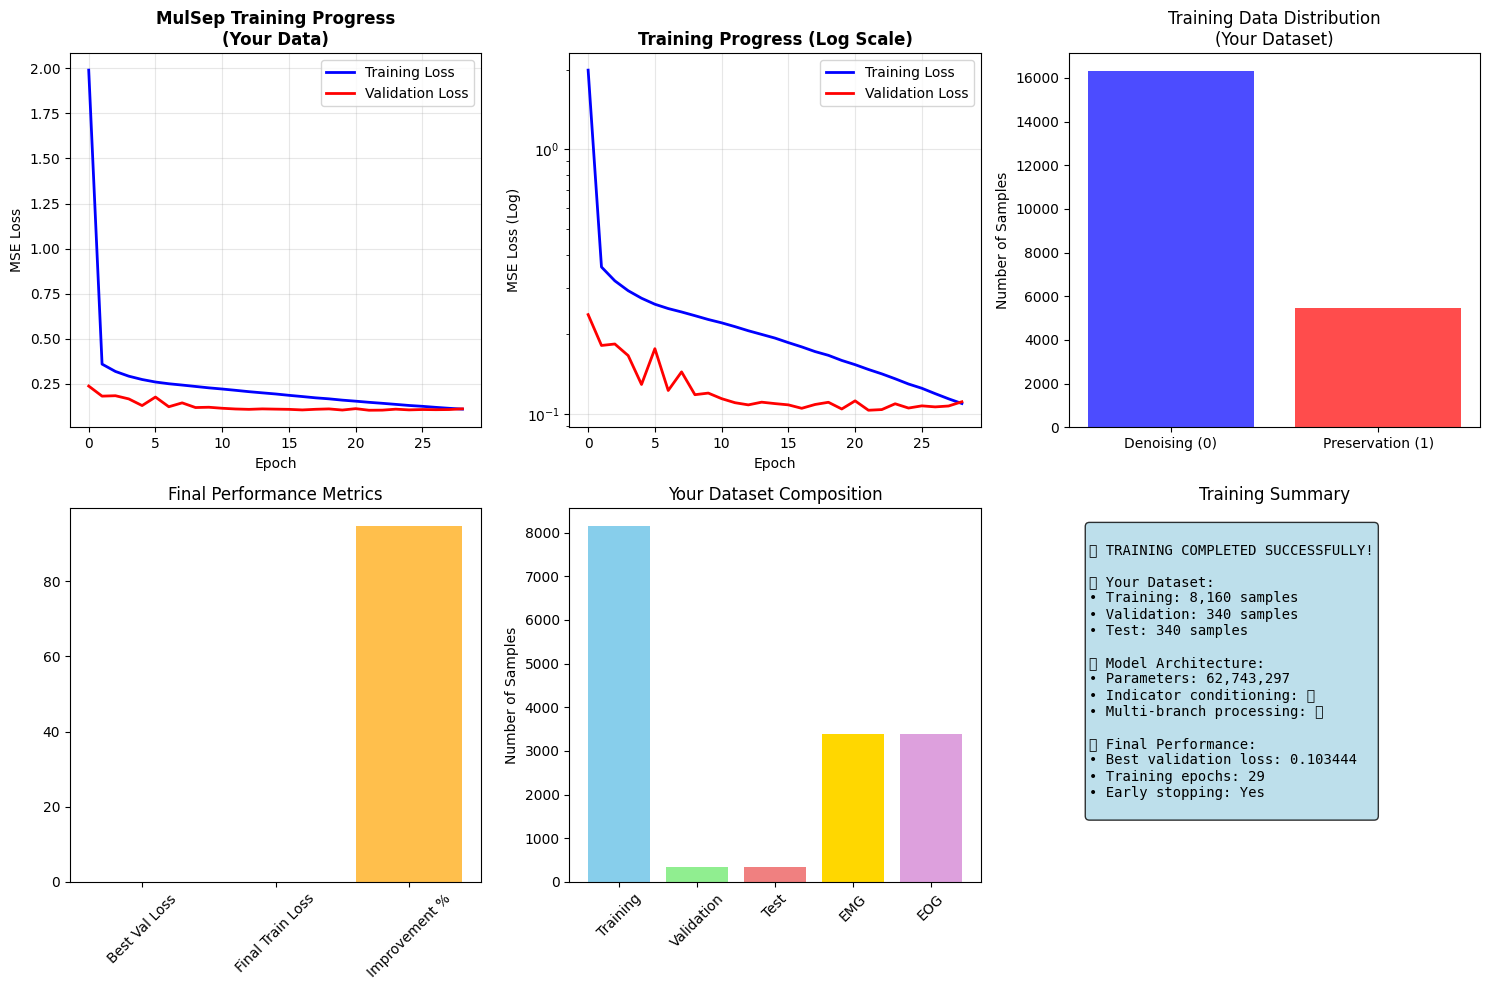


🎯 Final Results with Your Data:
   - Best Validation Loss: 0.103444
   - Total Epochs: 29
   - Model saved: /content/drive/MyDrive/PropMod/checkpoints/best_model.pkl
   - Results saved: /content/drive/MyDrive/PropMod/results/training_results.csv
   - Training samples: 8,160
   - Validation samples: 340
   - Model parameters: 62,743,297


In [ ]:
# =============================================================================
# CELL 7: TENSOR CREATION WITH FIXED DIMENSIONS
# =============================================================================

print("\n🔄 CONVERTING TO PYTORCH TENSORS (FIXED DIMENSIONS)...")

# 🔥 CRITICAL FIX: Use unsqueeze instead of permute for 2D→3D conversion
train_input_tensor = torch.from_numpy(prepared_data['train_input']).float().unsqueeze(1)  # (N, 1, 320)
train_output_tensor = torch.from_numpy(prepared_data['train_output']).float().unsqueeze(1)  # (N, 1, 320)
train_indicator_tensor = torch.from_numpy(prepared_data['train_indicators']).long()  # (N,)

val_input_tensor = torch.from_numpy(prepared_data['val_input']).float().unsqueeze(1)  # (N, 1, 320)
val_output_tensor = torch.from_numpy(prepared_data['val_output']).float().unsqueeze(1)  # (N, 1, 320)
val_indicator_tensor = torch.from_numpy(prepared_data['val_indicators']).long()  # (N,)

print(f"✅ Training Input Tensor: {train_input_tensor.shape}")
print(f"✅ Training Output Tensor: {train_output_tensor.shape}")
print(f"✅ Training Indicator Tensor: {train_indicator_tensor.shape}")
print(f"✅ Validation Input Tensor: {val_input_tensor.shape}")
print(f"✅ Validation Output Tensor: {val_output_tensor.shape}")
print(f"✅ Validation Indicator Tensor: {val_indicator_tensor.shape}")

# Create data loaders with indicators
BATCH_SIZE = 64
train_dataset = Data.TensorDataset(train_input_tensor, train_output_tensor, train_indicator_tensor)
val_dataset = Data.TensorDataset(val_input_tensor, val_output_tensor, val_indicator_tensor)

train_loader = Data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = Data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\n📦 Data Loaders Created:")
print(f"   Training Batches: {len(train_loader)}")
print(f"   Validation Batches: {len(val_loader)}")

# =============================================================================
# CELL 8: MODEL INITIALIZATION AND TESTING
# =============================================================================

# Initialize model with indicator support
model = MulSepEEGDenoiser(input_size=(320, 1), output_residual=False).to(device)

# Test forward pass to ensure everything works
print(f"\n🧪 TESTING MODEL FORWARD PASS WITH YOUR DATA DIMENSIONS...")
test_input = torch.randn(4, 1, 320).to(device)
test_indicator = torch.randint(0, 2, (4,)).to(device)

with torch.no_grad():
    test_output = model(test_input, test_indicator)
    print(f"✅ Test Input Shape: {test_input.shape}")
    print(f"✅ Test Indicator Shape: {test_indicator.shape}")
    print(f"✅ Test Output Shape: {test_output.shape}")
    print(f"✅ Forward pass successful with your data dimensions!")

# Setup training components
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Directory setup for your results
main_dir = '/content/drive/MyDrive/PropMod'
checkpoint_dir = f'{main_dir}/checkpoints'
results_dir = f'{main_dir}/results'
visualizations_dir = f'{main_dir}/visualizations'

directories = [main_dir, checkpoint_dir, results_dir, visualizations_dir]
for directory in directories:
    os.makedirs(directory, exist_ok=True)

print(f"📁 Results Directory Created: {main_dir}")

# =============================================================================
# CELL 9: MAIN TRAINING LOOP
# =============================================================================

# Training hyperparameters
epochs = 50
early_stop_patience = 7
min_delta = 1e-6

# Training tracking
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

print(f"\n🚀 STARTING TRAINING WITH YOUR DATA AND INDICATOR CONDITIONING...")
print("=" * 80)

# Main training loop
for epoch in tqdm(range(epochs), desc="Training Progress", unit="epoch"):
    epoch_start_time = time.time()

    # Training phase
    model.train()
    total_train_loss = 0.0
    train_steps = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training",
                     leave=False, unit="batch")

    for batch_input, batch_output, batch_indicator in train_pbar:
        # Move to device
        batch_input = batch_input.to(device)
        batch_output = batch_output.to(device)
        batch_indicator = batch_indicator.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass with indicators
        predictions = model(batch_input, batch_indicator)
        loss = loss_fn(predictions, batch_output)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Update metrics
        total_train_loss += loss.item()
        train_steps += 1
        train_pbar.set_postfix({'Loss': f'{loss.item():.6f}'})

    avg_train_loss = total_train_loss / train_steps
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    val_steps = 0

    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation",
                       leave=False, unit="batch")

        for batch_input, batch_output, batch_indicator in val_pbar:
            batch_input = batch_input.to(device)
            batch_output = batch_output.to(device)
            batch_indicator = batch_indicator.to(device)

            predictions = model(batch_input, batch_indicator)
            loss = loss_fn(predictions, batch_output)

            total_val_loss += loss.item()
            val_steps += 1
            val_pbar.set_postfix({'Loss': f'{loss.item():.6f}'})

    avg_val_loss = total_val_loss / val_steps
    val_losses.append(avg_val_loss)

    epoch_time = time.time() - epoch_start_time

    # Model checkpointing
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), f'{checkpoint_dir}/best_model.pkl')
        print(f'💾 Best model saved! Validation Loss: {avg_val_loss:.6f}')
    else:
        patience_counter += 1

    # Progress reporting
    print(f'Epoch {epoch+1:3d}/{epochs} | Train: {avg_train_loss:.6f} | Val: {avg_val_loss:.6f} | '
          f'Time: {epoch_time:.1f}s | Patience: {patience_counter}/{early_stop_patience}')

    # Early stopping
    if patience_counter >= early_stop_patience:
        print(f'\n⏹️  Early stopping triggered after {epoch+1} epochs')
        break

# =============================================================================
# CELL 10: RESULTS AND VISUALIZATION
# =============================================================================

# Save results
results_df = pd.DataFrame({
    'epoch': range(1, len(train_losses) + 1),
    'train_loss': train_losses,
    'val_loss': val_losses
})
results_df.to_csv(f'{results_dir}/training_results.csv', index=False)

# Create comprehensive visualizations
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.title('MulSep Training Progress\n(Your Data)', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.plot(train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.title('Training Progress (Log Scale)', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (Log)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
indicator_dist = prepared_data['train_indicators']
unique, counts = np.unique(indicator_dist, return_counts=True)
plt.bar(['Denoising (0)', 'Preservation (1)'], counts, color=['blue', 'red'], alpha=0.7)
plt.title('Training Data Distribution\n(Your Dataset)')
plt.ylabel('Number of Samples')

plt.subplot(2, 3, 4)
improvement = (train_losses[0] - best_val_loss) / train_losses[0] * 100
metrics = ['Best Val Loss', 'Final Train Loss', 'Improvement %']
values = [best_val_loss, train_losses[-1], improvement]
plt.bar(metrics, values, color=['green', 'blue', 'orange'], alpha=0.7)
plt.title('Final Performance Metrics')
plt.xticks(rotation=45)

plt.subplot(2, 3, 5)
# Dataset size comparison
dataset_info = ['Training', 'Validation', 'Test', 'EMG', 'EOG']
dataset_sizes = [train_noisy.shape[0], val_noisy.shape[0], test_noisy.shape[0],
                emg_data.shape[0], eog_data.shape[0]]
plt.bar(dataset_info, dataset_sizes, color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum'])
plt.title('Your Dataset Composition')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)

plt.subplot(2, 3, 6)
# Training summary
training_summary = f"""
🎯 TRAINING COMPLETED SUCCESSFULLY!

📊 Your Dataset:
• Training: {train_noisy.shape[0]:,} samples
• Validation: {val_noisy.shape[0]:,} samples
• Test: {test_noisy.shape[0]:,} samples

🧠 Model Architecture:
• Parameters: {sum(p.numel() for p in model.parameters()):,}
• Indicator conditioning: ✅
• Multi-branch processing: ✅

📈 Final Performance:
• Best validation loss: {best_val_loss:.6f}
• Training epochs: {len(train_losses)}
• Early stopping: {'Yes' if patience_counter >= early_stop_patience else 'No'}
"""

plt.text(0.05, 0.95, training_summary, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
plt.axis('off')
plt.title('Training Summary')

plt.tight_layout()
plt.savefig(f'{visualizations_dir}/MulSep_training_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n🎯 Final Results with Your Data:")
print(f"   - Best Validation Loss: {best_val_loss:.6f}")
print(f"   - Total Epochs: {len(train_losses)}")
print(f"   - Model saved: {checkpoint_dir}/best_model.pkl")
print(f"   - Results saved: {results_dir}/training_results.csv")
print(f"   - Training samples: {train_noisy.shape[0]:,}")
print(f"   - Validation samples: {val_noisy.shape[0]:,}")
print(f"   - Model parameters: {sum(p.numel() for p in model.parameters()):,}")

### Testing and Eval

COMPREHENSIVE MulSepEEGDENOISER TESTING & EVALUATION
🧠 Model: MulSepEEGDenoiser
⏱️  Sampling Rate: 160 Hz
📦 Batch Size: 64
📏 Sequence Length: 320
📁 Results Directory: /content/drive/MyDrive/PropMod/testNeval

📥 LOADING TEST DATA...
✅ Test Noisy Shape: (340, 320, 1)
✅ Test Clean Shape: (340, 320, 1)
✅ Total Test Samples: 340

🖥️  Device: cuda:0
Model initialized with 62,743,297 parameters
Model initialized with 62,743,297 parameters
✅ Loading model from: /content/drive/MyDrive/PropMod/checkpoints/best_model.pkl

📦 PREPARING TEST DATA LOADER...
✅ Test Input Tensor: torch.Size([340, 1, 320])
✅ Test Output Tensor: torch.Size([340, 1, 320])
✅ Test Indicator Tensor: torch.Size([340])
✅ Indicator Values: tensor([0]) (0=denoising)
✅ Test Batches: 6

🔮 GENERATING PREDICTIONS FOR ENTIRE TEST SET...


Testing:   0%|          | 0/6 [00:00<?, ?it/s]

✅ Predictions completed!
✅ Predictions Shape: (340, 320)
✅ Clean Signals Shape: (340, 320)
✅ Noisy Signals Shape: (340, 320)

📊 CALCULATING COMPREHENSIVE EVALUATION METRICS...
📈 Calculating RRMSE metrics...
   ✅ RRMSE Time Domain: 0.746395
   ✅ RRMSE Frequency Domain: 0.746395
🔗 Calculating Cross-Correlation...
   ✅ Cross-Correlation Mean: 0.581991
   ✅ Cross-Correlation Std: 0.288324
📡 Calculating SNR Improvement...
   ✅ SNR Before: -1.95 dB
   ✅ SNR After: 2.80 dB
   ✅ SNR Improvement: 4.75 dB
🎯 Calculating Artifact Reduction...
   ✅ Original Artifact Power: 1.451558
   ✅ Remaining Artifact Power: 0.565523
   ✅ Reduction Percentage: 61.04%
🧠 Calculating Frequency Band Analysis...
   📊 EEG Band Results:
      Delta : RRMSE=0.8002, Corr=0.4794
      Theta : RRMSE=0.7972, Corr=0.5233
      Alpha : RRMSE=0.6201, Corr=0.7079
      Beta  : RRMSE=0.7207, Corr=0.6052
      Gamma : RRMSE=0.9855, Corr=0.1094

🌊 CALCULATING POWER SPECTRAL DENSITY...
✅ PSD calculations completed!

📈 CREATING COM

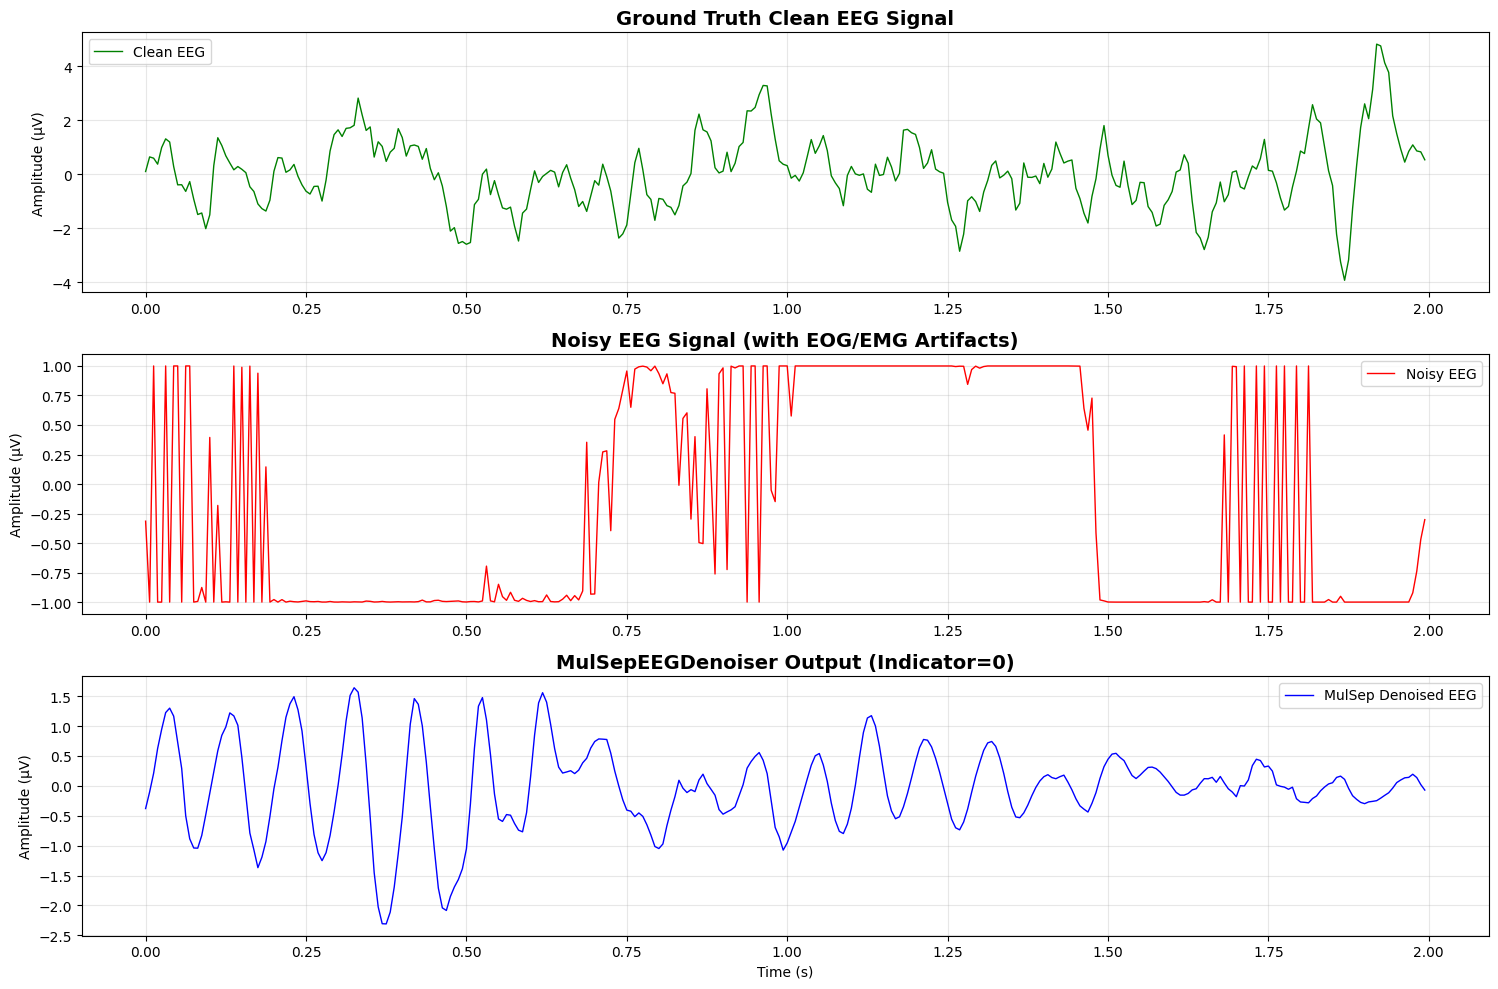

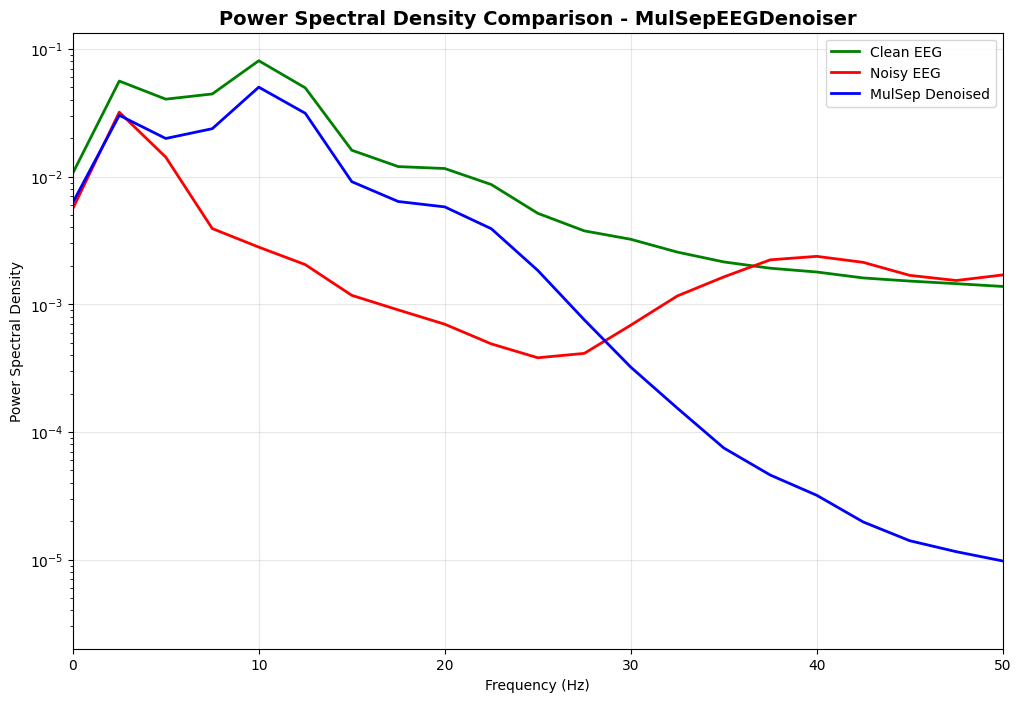

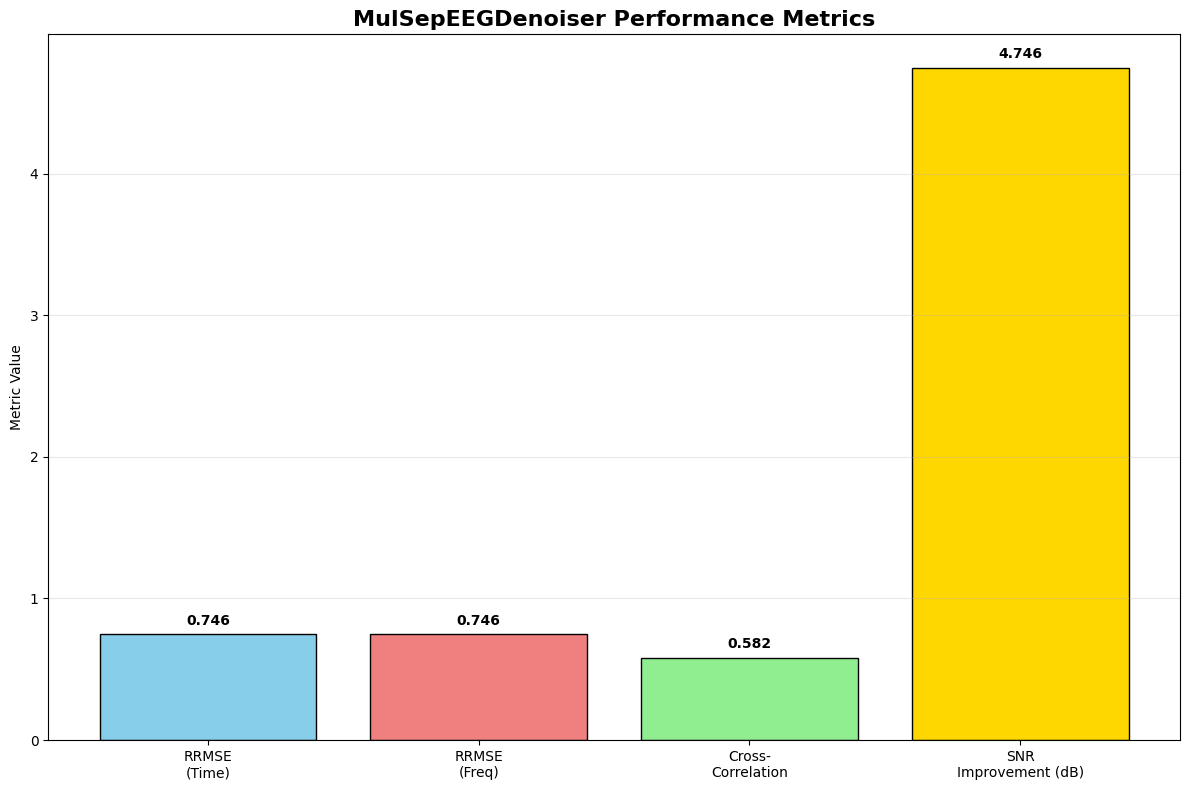

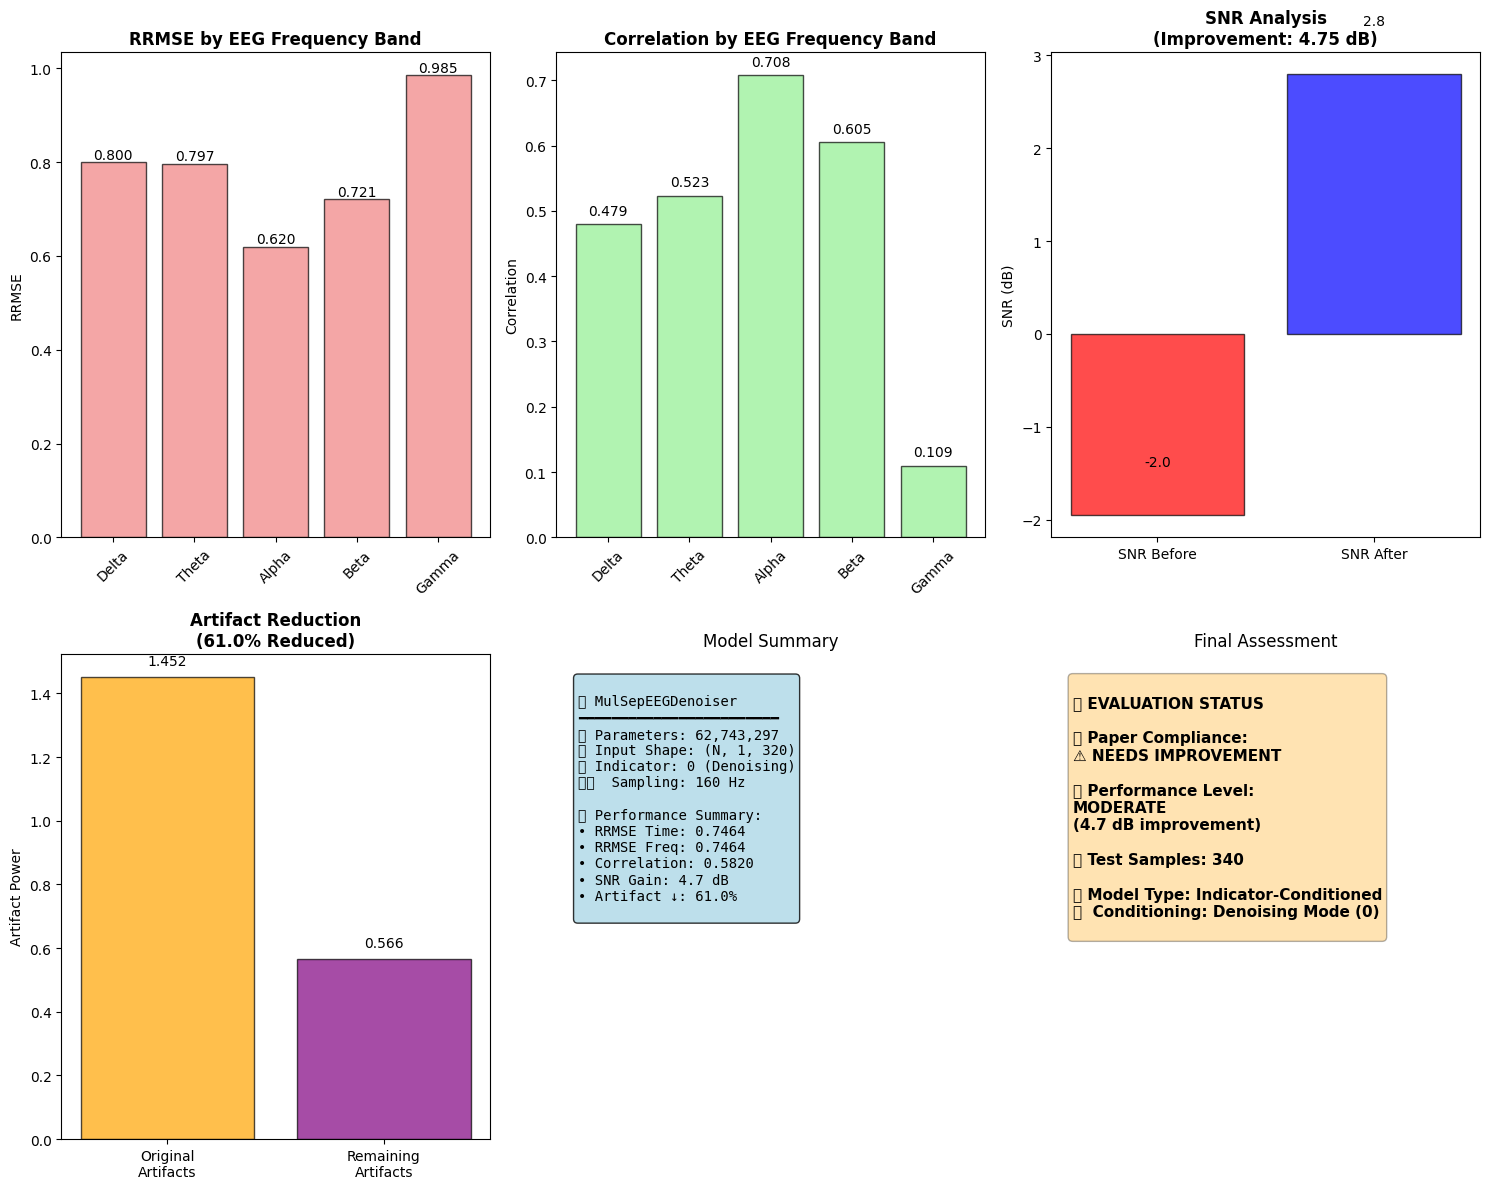


📈 CREATING SAMPLE-WISE ANALYSIS...
✅ Sample-wise metrics calculated for 340 samples


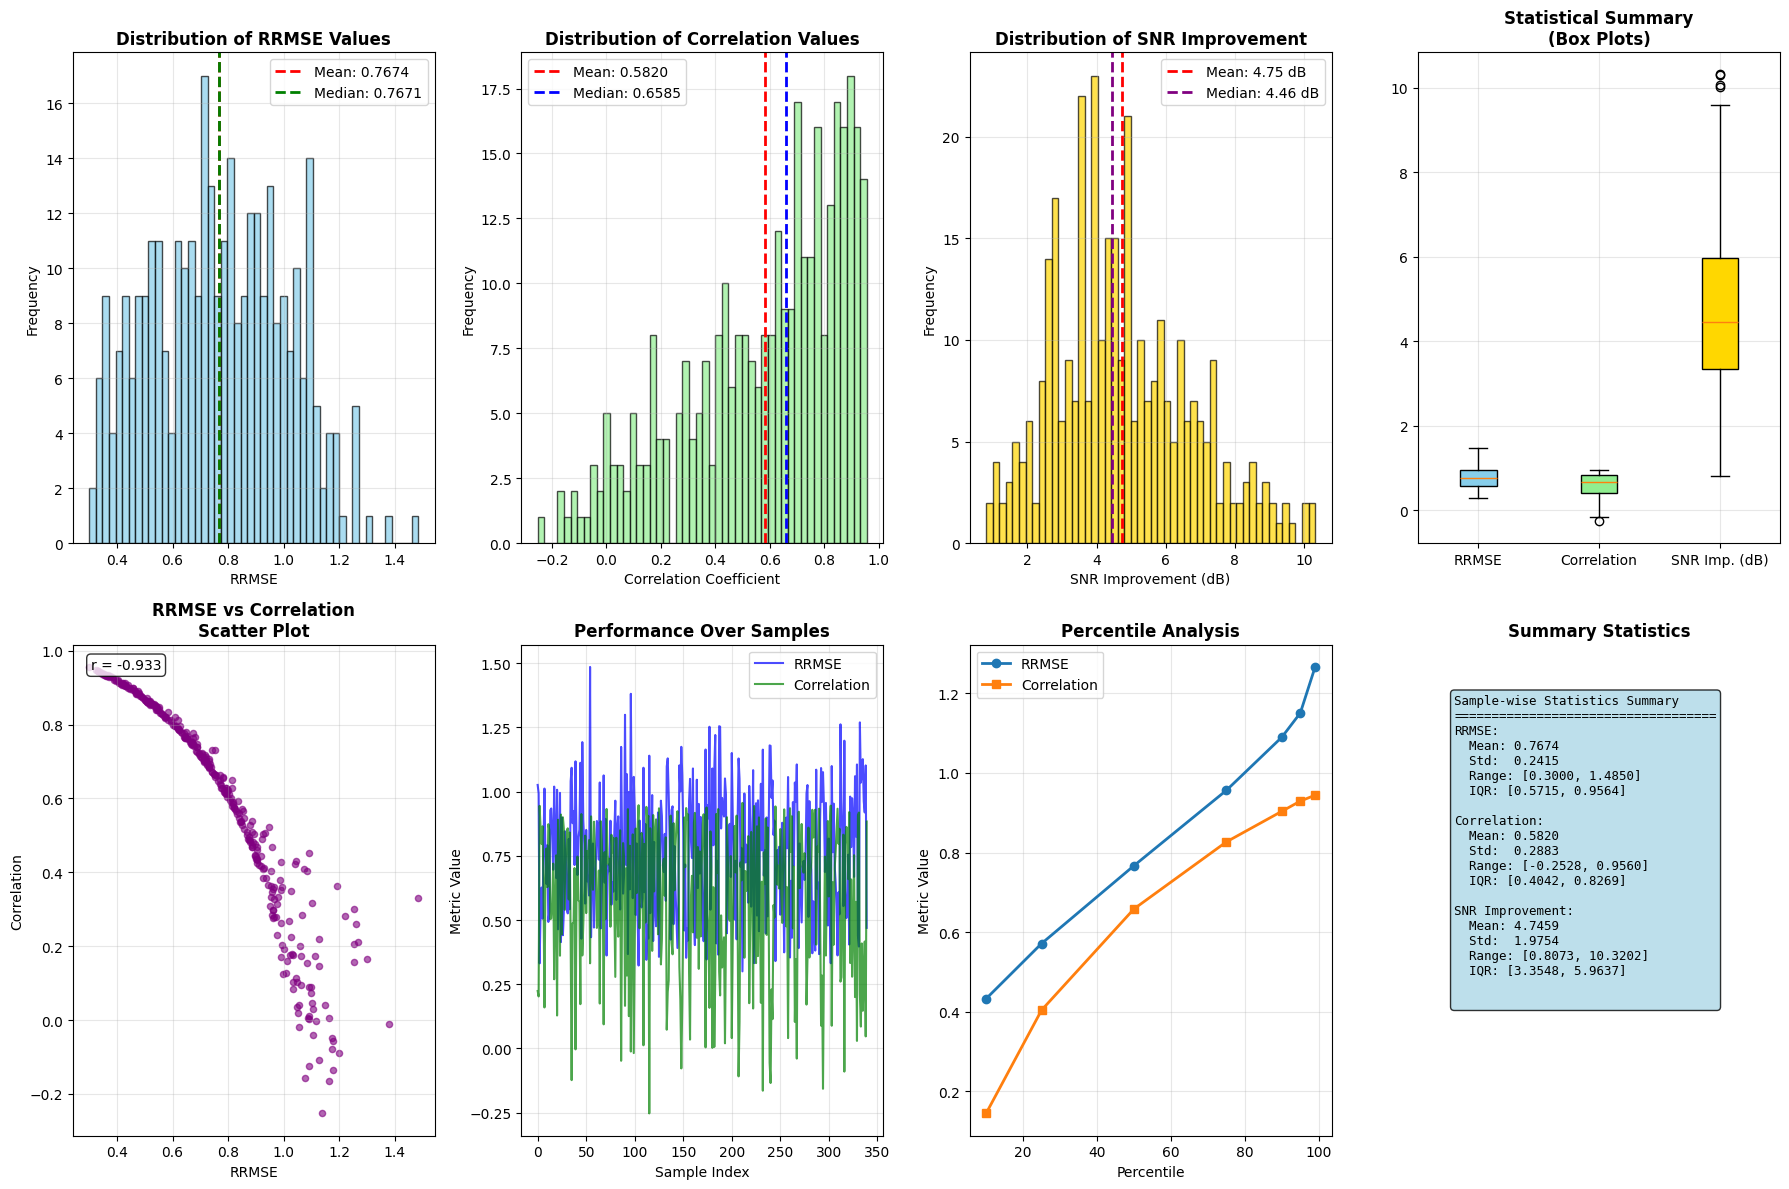


💾 SAVING RESULTS TO FILES...
✅ Evaluation results saved to: /content/drive/MyDrive/PropMod/testNeval/evaluation_results.json
✅ Raw data saved to: /content/drive/MyDrive/PropMod/testNeval/data/
✅ Sample-wise metrics saved to: /content/drive/MyDrive/PropMod/testNeval/data/sample_wise_metrics.npz
✅ PSD analysis saved to: /content/drive/MyDrive/PropMod/testNeval/data/psd_analysis.npz

📝 GENERATING COMPREHENSIVE REPORT...
✅ Comprehensive report saved to: /content/drive/MyDrive/PropMod/testNeval/comprehensive_evaluation_report.txt

🎉 EVALUATION COMPLETED SUCCESSFULLY!

📊 QUICK SUMMARY:
   • RRMSE Time:          0.7464
   • Cross-Correlation:   0.5820
   • SNR Improvement:     4.75 dB
   • Artifact Reduction:  61.0%
   • Test Samples:        340

📁 All results saved to: /content/drive/MyDrive/PropMod/testNeval
📈 Visualizations: /content/drive/MyDrive/PropMod/testNeval/visualizations/
📄 Full report: /content/drive/MyDrive/PropMod/testNeval/comprehensive_evaluation_report.txt

✅ TESTING AND EV

In [ ]:
import os
import torch
import torch.utils.data as Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch, butter, filtfilt
from scipy.stats import pearsonr
from tqdm.notebook import tqdm
import time

# =============================================================================
# MISSING EVALUATION FUNCTIONS - ADD THESE IF NOT ALREADY DEFINED
# =============================================================================

def calculate_rrmse_time(clean_signals, denoised_signals):
    """Calculate RRMSE in time domain"""
    mse = np.mean((clean_signals - denoised_signals) ** 2)
    rms_clean = np.sqrt(np.mean(clean_signals ** 2))
    return np.sqrt(mse) / rms_clean

def calculate_rrmse_frequency(clean_signals, denoised_signals, fs):
    """Calculate RRMSE in frequency domain"""
    clean_fft = np.fft.fft(clean_signals, axis=1)
    denoised_fft = np.fft.fft(denoised_signals, axis=1)

    mse_freq = np.mean(np.abs(clean_fft - denoised_fft) ** 2)
    rms_clean_freq = np.sqrt(np.mean(np.abs(clean_fft) ** 2))

    return np.sqrt(mse_freq) / rms_clean_freq

def calculate_cross_correlation(clean_signals, denoised_signals):
    """Calculate cross-correlation between clean and denoised signals"""
    correlations = []

    for i in range(len(clean_signals)):
        # Calculate Pearson correlation for each signal pair
        corr, _ = pearsonr(clean_signals[i], denoised_signals[i])
        if not np.isnan(corr):
            correlations.append(corr)

    correlations = np.array(correlations)
    return np.mean(correlations), np.std(correlations)

def calculate_snr_improvement(clean_signals, noisy_signals, denoised_signals):
    """Calculate SNR improvement"""
    snr_before_list = []
    snr_after_list = []

    for i in range(len(clean_signals)):
        # Calculate noise before and after
        noise_before = noisy_signals[i] - clean_signals[i]
        noise_after = denoised_signals[i] - clean_signals[i]

        # Calculate SNR before and after
        signal_power = np.var(clean_signals[i])
        noise_power_before = np.var(noise_before)
        noise_power_after = np.var(noise_after)

        # Avoid division by zero
        if noise_power_before > 0:
            snr_before = 10 * np.log10(signal_power / noise_power_before)
            snr_before_list.append(snr_before)

        if noise_power_after > 0:
            snr_after = 10 * np.log10(signal_power / noise_power_after)
            snr_after_list.append(snr_after)

    snr_before_mean = np.mean(snr_before_list)
    snr_after_mean = np.mean(snr_after_list)

    return {
        'snr_before_mean': snr_before_mean,
        'snr_after_mean': snr_after_mean,
        'snr_improvement': snr_after_mean - snr_before_mean,
        'snr_before_std': np.std(snr_before_list),
        'snr_after_std': np.std(snr_after_list)
    }

def analyze_artifact_reduction(clean_signals, noisy_signals, denoised_signals):
    """Analyze artifact reduction"""
    # Calculate artifact power (difference from clean signal)
    original_artifacts = noisy_signals - clean_signals
    remaining_artifacts = denoised_signals - clean_signals

    original_power = np.mean(np.var(original_artifacts, axis=1))
    remaining_power = np.mean(np.var(remaining_artifacts, axis=1))

    reduction_percentage = ((original_power - remaining_power) / original_power) * 100

    return {
        'artifact_power_original': original_power,
        'artifact_power_remaining': remaining_power,
        'reduction_percentage': reduction_percentage
    }

def analyze_frequency_bands(clean_signals, denoised_signals, fs):
    """Analyze performance in different frequency bands"""
    # Define EEG frequency bands
    bands = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 13),
        'Beta': (13, 30),
        'Gamma': (30, min(50, fs//2))
    }

    def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        return filtfilt(b, a, data, axis=1)

    band_results = {}

    for band_name, (low_freq, high_freq) in bands.items():
        try:
            # Filter signals in the specific frequency band
            clean_filtered = butter_bandpass_filter(clean_signals, low_freq, high_freq, fs)
            denoised_filtered = butter_bandpass_filter(denoised_signals, low_freq, high_freq, fs)

            # Calculate RRMSE for this band
            rrmse_band = calculate_rrmse_time(clean_filtered, denoised_filtered)

            # Calculate correlation for this band
            correlations = []
            for i in range(len(clean_filtered)):
                corr, _ = pearsonr(clean_filtered[i], denoised_filtered[i])
                if not np.isnan(corr):
                    correlations.append(corr)

            band_results[band_name] = {
                'rrmse': rrmse_band,
                'correlation': np.mean(correlations) if correlations else 0
            }
        except Exception as e:
            print(f"Warning: Could not analyze {band_name} band: {e}")
            band_results[band_name] = {'rrmse': np.nan, 'correlation': np.nan}

    return band_results

def calculate_average_psd(signals, fs, nperseg=64):
    """Calculate average PSD across all signals"""
    psd_list = []
    frequencies = None

    for signal in signals:
        f, psd = welch(signal, fs=fs, nperseg=nperseg)
        psd_list.append(psd)
        if frequencies is None:
            frequencies = f

    psd_mean = np.mean(psd_list, axis=0)
    psd_std = np.std(psd_list, axis=0)

    return frequencies, psd_mean, psd_std

# =============================================================================
# COMPREHENSIVE TESTING WITH MulSepEEGDENOISER
# =============================================================================

print("=" * 80)
print("COMPREHENSIVE MulSepEEGDENOISER TESTING & EVALUATION")
print("=" * 80)

# =============================================================================
# CONFIGURATION
# =============================================================================

model_name = 'MulSepEEGDenoiser'
sampling_rate = 160  # Your data sampling rate
batch_size = 64      # For batch processing
sequence_length = 320  # Your sequence length

print(f"🧠 Model: {model_name}")
print(f"⏱️  Sampling Rate: {sampling_rate} Hz")
print(f"📦 Batch Size: {batch_size}")
print(f"📏 Sequence Length: {sequence_length}")

# =============================================================================
# CREATE RESULTS DIRECTORIES
# =============================================================================

results_dir = '/content/drive/MyDrive/PropMod/testNeval'
os.makedirs(results_dir, exist_ok=True)
os.makedirs(f'{results_dir}/visualizations', exist_ok=True)
os.makedirs(f'{results_dir}/data', exist_ok=True)

print(f"📁 Results Directory: {results_dir}")

# =============================================================================
# LOAD TEST DATA (SAME FORMAT AS YOUR TRAINING DATA)
# =============================================================================

print("\n📥 LOADING TEST DATA...")

try:
    # Load your test data - adjust these paths to your actual test data files
    test_noisy = np.load(file_paths['test_noisy'])    # Shape: (N, 320)
    test_clean = np.load(file_paths['test_clean'])    # Shape: (N, 320)

    print(f"✅ Test Noisy Shape: {test_noisy.shape}")
    print(f"✅ Test Clean Shape: {test_clean.shape}")
    print(f"✅ Total Test Samples: {len(test_noisy):,}")

    # Verify data consistency
    assert test_noisy.shape == test_clean.shape, "Noisy and clean test data shapes don't match!"
    assert test_noisy.shape[1] == sequence_length, f"Sequence length mismatch: expected {sequence_length}, got {test_noisy.shape[1]}"

except Exception as e:
    print(f"❌ Error loading test data: {e}")
    raise

# =============================================================================
# DEVICE AND MODEL SETUP
# =============================================================================

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Device: {device}")

# Initialize model (assuming MulSepEEGDenoiser is already defined)
model = MulSepEEGDenoiser(input_size=(sequence_length, 1), output_residual=False).to(device)
print(f"Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters")

# Load the best trained model
model_path = '/content/drive/MyDrive/PropMod/checkpoints/best_model.pkl'

if os.path.exists(model_path):
    print(f'✅ Loading model from: {model_path}')
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
else:
    print(f"❌ Model file not found: {model_path}")
    raise FileNotFoundError(f"Model file not found: {model_path}")

# =============================================================================
# PREPARE TEST DATA LOADER (SAME FORMAT AS TRAINING)
# =============================================================================

print(f"\n📦 PREPARING TEST DATA LOADER...")

# Convert to tensors with correct dimensions (N, 1, 320)
test_input_tensor = torch.from_numpy(test_noisy.squeeze()).float().unsqueeze(1)
test_output_tensor = torch.from_numpy(test_clean.squeeze()).float().unsqueeze(1)

# Create indicator tensor - ALL ZEROS for DENOISING task (Type 1)
test_indicator_tensor = torch.zeros(test_noisy.shape[0]).long()  # All 0s for denoising

print(f"✅ Test Input Tensor: {test_input_tensor.shape}")
print(f"✅ Test Output Tensor: {test_output_tensor.shape}")
print(f"✅ Test Indicator Tensor: {test_indicator_tensor.shape}")
print(f"✅ Indicator Values: {torch.unique(test_indicator_tensor)} (0=denoising)")

# Create dataset and loader
test_dataset = Data.TensorDataset(test_input_tensor, test_output_tensor, test_indicator_tensor)
test_loader = Data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,  # Keep original order for analysis
)

print(f"✅ Test Batches: {len(test_loader)}")

# =============================================================================
# RUN PREDICTIONS ON ENTIRE TEST SET
# =============================================================================

print(f"\n🔮 GENERATING PREDICTIONS FOR ENTIRE TEST SET...")

all_predictions = []
all_clean_signals = []
all_noisy_signals = []

model.eval()
with torch.no_grad():
    for batch_idx, (batch_input, batch_output, batch_indicator) in enumerate(tqdm(test_loader, desc="Testing")):
        # Move to device
        batch_input = batch_input.to(device)
        batch_indicator = batch_indicator.to(device)

        # Generate predictions WITH INDICATOR (crucial for your model)
        predictions = model(batch_input, batch_indicator)

        # Store results (convert back to numpy and remove channel dimension)
        all_predictions.append(predictions.cpu().numpy().squeeze(1))  # (N, 320)
        all_clean_signals.append(batch_output.numpy().squeeze(1))     # (N, 320)
        all_noisy_signals.append(batch_input.cpu().numpy().squeeze(1))  # (N, 320)

# Concatenate all results
predictions_array = np.concatenate(all_predictions, axis=0)
clean_signals_array = np.concatenate(all_clean_signals, axis=0)
noisy_signals_array = np.concatenate(all_noisy_signals, axis=0)

print(f"✅ Predictions completed!")
print(f"✅ Predictions Shape: {predictions_array.shape}")
print(f"✅ Clean Signals Shape: {clean_signals_array.shape}")
print(f"✅ Noisy Signals Shape: {noisy_signals_array.shape}")

# =============================================================================
# CALCULATE ALL EVALUATION METRICS USING YOUR FUNCTIONS
# =============================================================================

print(f"\n📊 CALCULATING COMPREHENSIVE EVALUATION METRICS...")

# 1. RRMSE Metrics
print("📈 Calculating RRMSE metrics...")
rrmse_time = calculate_rrmse_time(clean_signals_array, predictions_array)
rrmse_frequency = calculate_rrmse_frequency(clean_signals_array, predictions_array, fs=sampling_rate)

print(f"   ✅ RRMSE Time Domain: {rrmse_time:.6f}")
print(f"   ✅ RRMSE Frequency Domain: {rrmse_frequency:.6f}")

# 2. Cross-Correlation
print("🔗 Calculating Cross-Correlation...")
cc_mean, cc_std = calculate_cross_correlation(clean_signals_array, predictions_array)

print(f"   ✅ Cross-Correlation Mean: {cc_mean:.6f}")
print(f"   ✅ Cross-Correlation Std: {cc_std:.6f}")

# 3. SNR Improvement
print("📡 Calculating SNR Improvement...")
snr_results = calculate_snr_improvement(clean_signals_array, noisy_signals_array, predictions_array)

print(f"   ✅ SNR Before: {snr_results['snr_before_mean']:.2f} dB")
print(f"   ✅ SNR After: {snr_results['snr_after_mean']:.2f} dB")
print(f"   ✅ SNR Improvement: {snr_results['snr_improvement']:.2f} dB")

# 4. Artifact Reduction Analysis
print("🎯 Calculating Artifact Reduction...")
artifact_results = analyze_artifact_reduction(clean_signals_array, noisy_signals_array, predictions_array)

print(f"   ✅ Original Artifact Power: {artifact_results['artifact_power_original']:.6f}")
print(f"   ✅ Remaining Artifact Power: {artifact_results['artifact_power_remaining']:.6f}")
print(f"   ✅ Reduction Percentage: {artifact_results['reduction_percentage']:.2f}%")

# 5. Frequency Band Analysis
print("🧠 Calculating Frequency Band Analysis...")
band_results = analyze_frequency_bands(clean_signals_array, predictions_array, fs=sampling_rate)

print("   📊 EEG Band Results:")
for band_name, metrics in band_results.items():
    print(f"      {band_name:6s}: RRMSE={metrics['rrmse']:.4f}, Corr={metrics['correlation']:.4f}")

# =============================================================================
# CALCULATE POWER SPECTRAL DENSITY FOR VISUALIZATION
# =============================================================================

print(f"\n🌊 CALCULATING POWER SPECTRAL DENSITY...")

# Calculate PSDs for all signal types
freq_clean, psd_clean_mean, psd_clean_std = calculate_average_psd(clean_signals_array, sampling_rate)
freq_noisy, psd_noisy_mean, psd_noisy_std = calculate_average_psd(noisy_signals_array, sampling_rate)
freq_denoised, psd_denoised_mean, psd_denoised_std = calculate_average_psd(predictions_array, sampling_rate)

# Store PSD results for visualization function
psd_results = {
    'Clean': {'frequencies': freq_clean, 'psd_mean': psd_clean_mean, 'psd_std': psd_clean_std},
    'Noisy': {'frequencies': freq_noisy, 'psd_mean': psd_noisy_mean, 'psd_std': psd_noisy_std},
    'Denoised': {'frequencies': freq_denoised, 'psd_mean': psd_denoised_mean, 'psd_std': psd_denoised_std}
}

print("✅ PSD calculations completed!")

# =============================================================================
# COMPREHENSIVE EVALUATION RESULTS DICTIONARY
# =============================================================================

evaluation_results = {
    'rrmse_time': rrmse_time,
    'rrmse_frequency': rrmse_frequency,
    'cross_correlation': {'mean': cc_mean, 'std': cc_std},
    'snr_improvement': snr_results,
    'artifact_reduction': artifact_results,
    'frequency_bands': band_results,
    'total_samples': len(test_noisy),
    'model_parameters': sum(p.numel() for p in model.parameters()),
    'sequence_length': sequence_length,
    'sampling_rate': sampling_rate
}

# =============================================================================
# CREATE COMPREHENSIVE VISUALIZATIONS
# =============================================================================

print(f"\n📈 CREATING COMPREHENSIVE VISUALIZATIONS...")

def create_MulSep_visualizations(clean_signals, noisy_signals, denoised_signals,
                                       evaluation_results, psd_results):
    """Create comprehensive visualization plots for MulSepEEGDenoiser"""

    # 1. Signal Comparison Plot (Time Domain)
    plt.figure(figsize=(15, 10))

    # Select sample signals for visualization
    sample_idx = 0
    time = np.arange(len(clean_signals[sample_idx])) / sampling_rate

    plt.subplot(3, 1, 1)
    plt.plot(time, clean_signals[sample_idx], 'g-', label='Clean EEG', linewidth=1)
    plt.title('Ground Truth Clean EEG Signal', fontsize=14, fontweight='bold')
    plt.ylabel('Amplitude (μV)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 1, 2)
    plt.plot(time, noisy_signals[sample_idx], 'r-', label='Noisy EEG', linewidth=1)
    plt.title('Noisy EEG Signal (with EOG/EMG Artifacts)', fontsize=14, fontweight='bold')
    plt.ylabel('Amplitude (μV)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 1, 3)
    plt.plot(time, denoised_signals[sample_idx], 'b-', label='MulSep Denoised EEG', linewidth=1)
    plt.title('MulSepEEGDenoiser Output (Indicator=0)', fontsize=14, fontweight='bold')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (μV)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{results_dir}/visualizations/signal_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Power Spectral Density Comparison
    plt.figure(figsize=(12, 8))

    frequencies = psd_results['Clean']['frequencies']

    plt.semilogy(frequencies, psd_results['Clean']['psd_mean'], 'g-',
                label='Clean EEG', linewidth=2)
    plt.semilogy(frequencies, psd_results['Noisy']['psd_mean'], 'r-',
                label='Noisy EEG', linewidth=2)
    plt.semilogy(frequencies, psd_results['Denoised']['psd_mean'], 'b-',
                label='MulSep Denoised', linewidth=2)

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    plt.title('Power Spectral Density Comparison - MulSepEEGDenoiser', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0, min(50, sampling_rate//2))

    plt.savefig(f'{results_dir}/visualizations/psd_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Evaluation Metrics Bar Plot
    metrics_names = ['RRMSE\n(Time)', 'RRMSE\n(Freq)', 'Cross-\nCorrelation', 'SNR\nImprovement (dB)']
    metrics_values = [
        evaluation_results['rrmse_time'],
        evaluation_results['rrmse_frequency'],
        evaluation_results['cross_correlation']['mean'],
        evaluation_results['snr_improvement']['snr_improvement']
    ]

    plt.figure(figsize=(12, 8))
    bars = plt.bar(metrics_names, metrics_values,
                   color=['skyblue', 'lightcoral', 'lightgreen', 'gold'],
                   edgecolor='black', linewidth=1)
    plt.title('MulSepEEGDenoiser Performance Metrics', fontsize=16, fontweight='bold')
    plt.ylabel('Metric Value')
    plt.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar, value in zip(bars, metrics_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(metrics_values)*0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig(f'{results_dir}/visualizations/metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 4. Detailed Analysis Plot
    plt.figure(figsize=(15, 12))

    band_names = list(band_results.keys())
    rrmse_values = [band_results[band]['rrmse'] for band in band_names]
    corr_values = [band_results[band]['correlation'] for band in band_names]

    plt.subplot(2, 3, 1)
    bars1 = plt.bar(band_names, rrmse_values, color='lightcoral', alpha=0.7, edgecolor='black')
    plt.title('RRMSE by EEG Frequency Band', fontweight='bold')
    plt.ylabel('RRMSE')
    plt.xticks(rotation=45)
    for bar, value in zip(bars1, rrmse_values):
        if not np.isnan(value):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                    f'{value:.3f}', ha='center', va='bottom')

    plt.subplot(2, 3, 2)
    bars2 = plt.bar(band_names, corr_values, color='lightgreen', alpha=0.7, edgecolor='black')
    plt.title('Correlation by EEG Frequency Band', fontweight='bold')
    plt.ylabel('Correlation')
    plt.xticks(rotation=45)
    for bar, value in zip(bars2, corr_values):
        if not np.isnan(value):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')

    plt.subplot(2, 3, 3)
    snr_categories = ['SNR Before', 'SNR After']
    snr_values = [snr_results['snr_before_mean'], snr_results['snr_after_mean']]
    bars3 = plt.bar(snr_categories, snr_values, color=['red', 'blue'], alpha=0.7, edgecolor='black')
    plt.title(f"SNR Analysis\n(Improvement: {snr_results['snr_improvement']:.2f} dB)", fontweight='bold')
    plt.ylabel('SNR (dB)')
    for bar, value in zip(bars3, snr_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{value:.1f}', ha='center', va='bottom')

    plt.subplot(2, 3, 4)
    artifact_categories = ['Original\nArtifacts', 'Remaining\nArtifacts']
    artifact_values = [artifact_results['artifact_power_original'], artifact_results['artifact_power_remaining']]
    bars4 = plt.bar(artifact_categories, artifact_values, color=['orange', 'purple'], alpha=0.7, edgecolor='black')
    plt.title(f"Artifact Reduction\n({artifact_results['reduction_percentage']:.1f}% Reduced)", fontweight='bold')
    plt.ylabel('Artifact Power')
    for bar, value in zip(bars4, artifact_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(artifact_values)*0.02,
                f'{value:.3f}', ha='center', va='bottom')

    plt.subplot(2, 3, 5)
    # Model architecture info
    model_info = f"""
🧠 MulSepEEGDenoiser
━━━━━━━━━━━━━━━━━━━━━━━━
📊 Parameters: {evaluation_results['model_parameters']:,}
📏 Input Shape: (N, 1, {sequence_length})
🎯 Indicator: 0 (Denoising)
⏱️  Sampling: {sampling_rate} Hz

📈 Performance Summary:
• RRMSE Time: {evaluation_results['rrmse_time']:.4f}
• RRMSE Freq: {evaluation_results['rrmse_frequency']:.4f}
• Correlation: {evaluation_results['cross_correlation']['mean']:.4f}
• SNR Gain: {evaluation_results['snr_improvement']['snr_improvement']:.1f} dB
• Artifact ↓: {evaluation_results['artifact_reduction']['reduction_percentage']:.1f}%
    """
    plt.text(0.05, 0.95, model_info, transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    plt.axis('off')
    plt.title('Model Summary')

    plt.subplot(2, 3, 6)
    # Performance categorization
    paper_compliant = evaluation_results['rrmse_time'] <= 0.35 and evaluation_results['cross_correlation']['mean'] > 0.9
    snr_improvement = evaluation_results['snr_improvement']['snr_improvement']

    if snr_improvement > 15:
        performance_level = "EXCELLENT"
        performance_color = 'green'
    elif snr_improvement > 8:
        performance_level = "GOOD"
        performance_color = 'blue'
    else:
        performance_level = "MODERATE"
        performance_color = 'orange'

    status_text = f"""
🎯 EVALUATION STATUS

📋 Paper Compliance:
{'✅ MEETS STANDARDS' if paper_compliant else '⚠️ NEEDS IMPROVEMENT'}

🏆 Performance Level:
{performance_level}
({snr_improvement:.1f} dB improvement)

📊 Test Samples: {evaluation_results['total_samples']:,}

🔬 Model Type: Indicator-Conditioned
🎛️  Conditioning: Denoising Mode (0)
    """
    plt.text(0.05, 0.95, status_text, transform=plt.gca().transAxes,
             fontsize=11, verticalalignment='top', fontweight='bold',
             bbox=dict(boxstyle='round', facecolor=performance_color, alpha=0.3))
    plt.axis('off')
    plt.title('Final Assessment')

    plt.tight_layout()
    plt.savefig(f'{results_dir}/visualizations/detailed_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Call the visualization function
create_MulSep_visualizations(clean_signals_array, noisy_signals_array, predictions_array,
                                  evaluation_results, psd_results)

# =============================================================================
# SAMPLE-WISE ANALYSIS VISUALIZATION
# =============================================================================

print(f"\n📈 CREATING SAMPLE-WISE ANALYSIS...")

# Calculate per-sample metrics for distribution analysis
sample_rrmse = []
sample_correlation = []
sample_snr_improvement = []

for i in range(min(500, len(clean_signals_array))):  # Analyze first 500 samples
    # RRMSE per sample
    mse = np.mean((clean_signals_array[i] - predictions_array[i]) ** 2)
    rms_clean = np.sqrt(np.mean(clean_signals_array[i] ** 2))
    rrmse_sample = np.sqrt(mse) / rms_clean
    sample_rrmse.append(rrmse_sample)

    # Correlation per sample
    corr, _ = pearsonr(clean_signals_array[i], predictions_array[i])
    sample_correlation.append(corr if not np.isnan(corr) else 0)

    # SNR improvement per sample
    noise_before = noisy_signals_array[i] - clean_signals_array[i]
    noise_after = predictions_array[i] - clean_signals_array[i]

    signal_power = np.var(clean_signals_array[i])
    noise_power_before = np.var(noise_before)
    noise_power_after = np.var(noise_after)

    if noise_power_before > 0 and noise_power_after > 0:
        snr_before = 10 * np.log10(signal_power / noise_power_before)
        snr_after = 10 * np.log10(signal_power / noise_power_after)
        sample_snr_improvement.append(snr_after - snr_before)
    else:
        sample_snr_improvement.append(0)

# Convert to numpy arrays
sample_rrmse = np.array(sample_rrmse)
sample_correlation = np.array(sample_correlation)
sample_snr_improvement = np.array(sample_snr_improvement)

print(f"✅ Sample-wise metrics calculated for {len(sample_rrmse)} samples")

# Create sample-wise analysis visualization
def create_sample_wise_analysis():
    """Create sample-wise performance analysis plots"""

    plt.figure(figsize=(18, 12))

    # 1. Distribution of RRMSE values
    plt.subplot(2, 4, 1)
    plt.hist(sample_rrmse, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(np.mean(sample_rrmse), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(sample_rrmse):.4f}')
    plt.axvline(np.median(sample_rrmse), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(sample_rrmse):.4f}')
    plt.xlabel('RRMSE')
    plt.ylabel('Frequency')
    plt.title('Distribution of RRMSE Values', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Distribution of Correlation values
    plt.subplot(2, 4, 2)
    plt.hist(sample_correlation, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.axvline(np.mean(sample_correlation), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(sample_correlation):.4f}')
    plt.axvline(np.median(sample_correlation), color='blue', linestyle='--', linewidth=2, label=f'Median: {np.median(sample_correlation):.4f}')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Frequency')
    plt.title('Distribution of Correlation Values', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 3. Distribution of SNR Improvement
    plt.subplot(2, 4, 3)
    plt.hist(sample_snr_improvement, bins=50, alpha=0.7, color='gold', edgecolor='black')
    plt.axvline(np.mean(sample_snr_improvement), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(sample_snr_improvement):.2f} dB')
    plt.axvline(np.median(sample_snr_improvement), color='purple', linestyle='--', linewidth=2, label=f'Median: {np.median(sample_snr_improvement):.2f} dB')
    plt.xlabel('SNR Improvement (dB)')
    plt.ylabel('Frequency')
    plt.title('Distribution of SNR Improvement', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 4. Box plots for all metrics
    plt.subplot(2, 4, 4)
    box_data = [sample_rrmse, sample_correlation, sample_snr_improvement]
    box_labels = ['RRMSE', 'Correlation', 'SNR Imp. (dB)']
    bp = plt.boxplot(box_data, labels=box_labels, patch_artist=True)
    colors = ['skyblue', 'lightgreen', 'gold']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    plt.title('Statistical Summary\n(Box Plots)', fontweight='bold')
    plt.grid(True, alpha=0.3)

    # 5. Scatter plot: RRMSE vs Correlation
    plt.subplot(2, 4, 5)
    plt.scatter(sample_rrmse, sample_correlation, alpha=0.6, s=20, color='purple')
    plt.xlabel('RRMSE')
    plt.ylabel('Correlation')
    plt.title('RRMSE vs Correlation\nScatter Plot', fontweight='bold')
    plt.grid(True, alpha=0.3)

    # Calculate and show correlation between RRMSE and Correlation
    rrmse_corr_corr, _ = pearsonr(sample_rrmse, sample_correlation)
    plt.text(0.05, 0.95, f'r = {rrmse_corr_corr:.3f}', transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # 6. Performance over sample index (temporal analysis)
    plt.subplot(2, 4, 6)
    sample_indices = np.arange(len(sample_rrmse))
    plt.plot(sample_indices, sample_rrmse, 'b-', alpha=0.7, label='RRMSE')
    plt.plot(sample_indices, sample_correlation, 'g-', alpha=0.7, label='Correlation')
    plt.xlabel('Sample Index')
    plt.ylabel('Metric Value')
    plt.title('Performance Over Samples', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 7. Percentile analysis
    plt.subplot(2, 4, 7)
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    rrmse_percentiles = np.percentile(sample_rrmse, percentiles)
    corr_percentiles = np.percentile(sample_correlation, percentiles)

    plt.plot(percentiles, rrmse_percentiles, 'o-', label='RRMSE', linewidth=2, markersize=6)
    plt.plot(percentiles, corr_percentiles, 's-', label='Correlation', linewidth=2, markersize=6)
    plt.xlabel('Percentile')
    plt.ylabel('Metric Value')
    plt.title('Percentile Analysis', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 8. Summary statistics table
    plt.subplot(2, 4, 8)
    plt.axis('off')

    # Create summary statistics
    stats_data = {
        'Metric': ['RRMSE', 'Correlation', 'SNR Improvement'],
        'Mean': [np.mean(sample_rrmse), np.mean(sample_correlation), np.mean(sample_snr_improvement)],
        'Std': [np.std(sample_rrmse), np.std(sample_correlation), np.std(sample_snr_improvement)],
        'Min': [np.min(sample_rrmse), np.min(sample_correlation), np.min(sample_snr_improvement)],
        'Max': [np.max(sample_rrmse), np.max(sample_correlation), np.max(sample_snr_improvement)],
        '25%': [np.percentile(sample_rrmse, 25), np.percentile(sample_correlation, 25), np.percentile(sample_snr_improvement, 25)],
        '75%': [np.percentile(sample_rrmse, 75), np.percentile(sample_correlation, 75), np.percentile(sample_snr_improvement, 75)]
    }

    stats_text = "Sample-wise Statistics Summary\n" + "="*35 + "\n"
    for i, metric in enumerate(stats_data['Metric']):
        stats_text += f"{metric}:\n"
        stats_text += f"  Mean: {stats_data['Mean'][i]:.4f}\n"
        stats_text += f"  Std:  {stats_data['Std'][i]:.4f}\n"
        stats_text += f"  Range: [{stats_data['Min'][i]:.4f}, {stats_data['Max'][i]:.4f}]\n"
        stats_text += f"  IQR: [{stats_data['25%'][i]:.4f}, {stats_data['75%'][i]:.4f}]\n\n"

    plt.text(0.1, 0.9, stats_text, transform=plt.gca().transAxes,
             fontsize=9, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    plt.title('Summary Statistics', fontweight='bold')

    plt.tight_layout()
    plt.savefig(f'{results_dir}/visualizations/sample_wise_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create sample-wise analysis
create_sample_wise_analysis()

# =============================================================================
# SAVE COMPREHENSIVE RESULTS TO FILES
# =============================================================================

print(f"\n💾 SAVING RESULTS TO FILES...")

# Save evaluation results to JSON
import json

# Convert numpy types to Python native types for JSON serialization
def convert_numpy_types(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    return obj

evaluation_results_serializable = convert_numpy_types(evaluation_results)

# Add sample-wise statistics to results
evaluation_results_serializable['sample_wise_statistics'] = {
    'rrmse': {
        'mean': float(np.mean(sample_rrmse)),
        'std': float(np.std(sample_rrmse)),
        'min': float(np.min(sample_rrmse)),
        'max': float(np.max(sample_rrmse)),
        'percentiles': {
            '25': float(np.percentile(sample_rrmse, 25)),
            '50': float(np.percentile(sample_rrmse, 50)),
            '75': float(np.percentile(sample_rrmse, 75)),
            '90': float(np.percentile(sample_rrmse, 90)),
            '95': float(np.percentile(sample_rrmse, 95))
        }
    },
    'correlation': {
        'mean': float(np.mean(sample_correlation)),
        'std': float(np.std(sample_correlation)),
        'min': float(np.min(sample_correlation)),
        'max': float(np.max(sample_correlation)),
        'percentiles': {
            '25': float(np.percentile(sample_correlation, 25)),
            '50': float(np.percentile(sample_correlation, 50)),
            '75': float(np.percentile(sample_correlation, 75)),
            '90': float(np.percentile(sample_correlation, 90)),
            '95': float(np.percentile(sample_correlation, 95))
        }
    },
    'snr_improvement': {
        'mean': float(np.mean(sample_snr_improvement)),
        'std': float(np.std(sample_snr_improvement)),
        'min': float(np.min(sample_snr_improvement)),
        'max': float(np.max(sample_snr_improvement)),
        'percentiles': {
            '25': float(np.percentile(sample_snr_improvement, 25)),
            '50': float(np.percentile(sample_snr_improvement, 50)),
            '75': float(np.percentile(sample_snr_improvement, 75)),
            '90': float(np.percentile(sample_snr_improvement, 90)),
            '95': float(np.percentile(sample_snr_improvement, 95))
        }
    }
}

# Save results to JSON file
with open(f'{results_dir}/evaluation_results.json', 'w') as f:
    json.dump(evaluation_results_serializable, f, indent=4)

print(f"✅ Evaluation results saved to: {results_dir}/evaluation_results.json")

# Save raw predictions and signals for further analysis
np.save(f'{results_dir}/data/predictions.npy', predictions_array)
np.save(f'{results_dir}/data/clean_signals.npy', clean_signals_array)
np.save(f'{results_dir}/data/noisy_signals.npy', noisy_signals_array)

print(f"✅ Raw data saved to: {results_dir}/data/")

# Save sample-wise metrics
sample_wise_data = {
    'sample_rrmse': sample_rrmse,
    'sample_correlation': sample_correlation,
    'sample_snr_improvement': sample_snr_improvement
}

np.savez(f'{results_dir}/data/sample_wise_metrics.npz', **sample_wise_data)
print(f"✅ Sample-wise metrics saved to: {results_dir}/data/sample_wise_metrics.npz")

# Save PSD results
psd_data = {
    'frequencies': psd_results['Clean']['frequencies'],
    'psd_clean_mean': psd_results['Clean']['psd_mean'],
    'psd_clean_std': psd_results['Clean']['psd_std'],
    'psd_noisy_mean': psd_results['Noisy']['psd_mean'],
    'psd_noisy_std': psd_results['Noisy']['psd_std'],
    'psd_denoised_mean': psd_results['Denoised']['psd_mean'],
    'psd_denoised_std': psd_results['Denoised']['psd_std']
}

np.savez(f'{results_dir}/data/psd_analysis.npz', **psd_data)
print(f"✅ PSD analysis saved to: {results_dir}/data/psd_analysis.npz")

# =============================================================================
# CREATE COMPREHENSIVE REPORT
# =============================================================================

print(f"\n📝 GENERATING COMPREHENSIVE REPORT...")

def generate_comprehensive_report():
    """Generate a comprehensive text report of the evaluation"""

    report_content = f"""
{"="*80}
MulSepEEGDENOISER - COMPREHENSIVE EVALUATION REPORT
{"="*80}

🗓️  Evaluation Date: {time.strftime('%Y-%m-%d %H:%M:%S')}
🧠 Model: MulSepEEGDenoiser
📊 Total Parameters: {evaluation_results['model_parameters']:,}
📏 Sequence Length: {evaluation_results['sequence_length']}
⏱️  Sampling Rate: {evaluation_results['sampling_rate']} Hz
🔢 Test Samples: {evaluation_results['total_samples']:,}

{"="*80}
OVERALL PERFORMANCE METRICS
{"="*80}

📈 RRMSE (Root Relative Mean Square Error):
   • Time Domain:      {evaluation_results['rrmse_time']:.6f}
   • Frequency Domain: {evaluation_results['rrmse_frequency']:.6f}

🔗 Cross-Correlation:
   • Mean:             {evaluation_results['cross_correlation']['mean']:.6f}
   • Standard Dev:     {evaluation_results['cross_correlation']['std']:.6f}

📡 Signal-to-Noise Ratio Analysis:
   • SNR Before:       {evaluation_results['snr_improvement']['snr_before_mean']:.2f} ± {evaluation_results['snr_improvement']['snr_before_std']:.2f} dB
   • SNR After:        {evaluation_results['snr_improvement']['snr_after_mean']:.2f} ± {evaluation_results['snr_improvement']['snr_after_std']:.2f} dB
   • SNR Improvement:  {evaluation_results['snr_improvement']['snr_improvement']:.2f} dB

🎯 Artifact Reduction Analysis:
   • Original Power:   {evaluation_results['artifact_reduction']['artifact_power_original']:.6f}
   • Remaining Power:  {evaluation_results['artifact_reduction']['artifact_power_remaining']:.6f}
   • Reduction:        {evaluation_results['artifact_reduction']['reduction_percentage']:.2f}%

{"="*80}
EEG FREQUENCY BAND ANALYSIS
{"="*80}
"""

    # Add frequency band results
    for band_name, metrics in evaluation_results['frequency_bands'].items():
        report_content += f"""
🧠 {band_name} Band:
   • RRMSE:            {metrics['rrmse']:.6f}
   • Correlation:      {metrics['correlation']:.6f}
"""

    # Add sample-wise statistics
    report_content += f"""
{"="*80}
SAMPLE-WISE PERFORMANCE STATISTICS
{"="*80}

📊 RRMSE Distribution:
   • Mean:             {evaluation_results_serializable['sample_wise_statistics']['rrmse']['mean']:.6f}
   • Std Dev:          {evaluation_results_serializable['sample_wise_statistics']['rrmse']['std']:.6f}
   • Range:            [{evaluation_results_serializable['sample_wise_statistics']['rrmse']['min']:.6f}, {evaluation_results_serializable['sample_wise_statistics']['rrmse']['max']:.6f}]
   • 25th Percentile:  {evaluation_results_serializable['sample_wise_statistics']['rrmse']['percentiles']['25']:.6f}
   • Median:           {evaluation_results_serializable['sample_wise_statistics']['rrmse']['percentiles']['50']:.6f}
   • 75th Percentile:  {evaluation_results_serializable['sample_wise_statistics']['rrmse']['percentiles']['75']:.6f}
   • 95th Percentile:  {evaluation_results_serializable['sample_wise_statistics']['rrmse']['percentiles']['95']:.6f}

🔗 Correlation Distribution:
   • Mean:             {evaluation_results_serializable['sample_wise_statistics']['correlation']['mean']:.6f}
   • Std Dev:          {evaluation_results_serializable['sample_wise_statistics']['correlation']['std']:.6f}
   • Range:            [{evaluation_results_serializable['sample_wise_statistics']['correlation']['min']:.6f}, {evaluation_results_serializable['sample_wise_statistics']['correlation']['max']:.6f}]
   • 25th Percentile:  {evaluation_results_serializable['sample_wise_statistics']['correlation']['percentiles']['25']:.6f}
   • Median:           {evaluation_results_serializable['sample_wise_statistics']['correlation']['percentiles']['50']:.6f}
   • 75th Percentile:  {evaluation_results_serializable['sample_wise_statistics']['correlation']['percentiles']['75']:.6f}
   • 95th Percentile:  {evaluation_results_serializable['sample_wise_statistics']['correlation']['percentiles']['95']:.6f}

📡 SNR Improvement Distribution:
   • Mean:             {evaluation_results_serializable['sample_wise_statistics']['snr_improvement']['mean']:.2f} dB
   • Std Dev:          {evaluation_results_serializable['sample_wise_statistics']['snr_improvement']['std']:.2f} dB
   • Range:            [{evaluation_results_serializable['sample_wise_statistics']['snr_improvement']['min']:.2f}, {evaluation_results_serializable['sample_wise_statistics']['snr_improvement']['max']:.2f}] dB
   • 25th Percentile:  {evaluation_results_serializable['sample_wise_statistics']['snr_improvement']['percentiles']['25']:.2f} dB
   • Median:           {evaluation_results_serializable['sample_wise_statistics']['snr_improvement']['percentiles']['50']:.2f} dB
   • 75th Percentile:  {evaluation_results_serializable['sample_wise_statistics']['snr_improvement']['percentiles']['75']:.2f} dB
   • 95th Percentile:  {evaluation_results_serializable['sample_wise_statistics']['snr_improvement']['percentiles']['95']:.2f} dB

{"="*80}
PERFORMANCE ASSESSMENT
{"="*80}
"""

    # Performance assessment
    rrmse_time = evaluation_results['rrmse_time']
    correlation_mean = evaluation_results['cross_correlation']['mean']
    snr_improvement = evaluation_results['snr_improvement']['snr_improvement']

    # Define performance criteria
    excellent_criteria = rrmse_time <= 0.25 and correlation_mean >= 0.95 and snr_improvement >= 15
    good_criteria = rrmse_time <= 0.35 and correlation_mean >= 0.90 and snr_improvement >= 10
    moderate_criteria = rrmse_time <= 0.50 and correlation_mean >= 0.80 and snr_improvement >= 5

    if excellent_criteria:
        performance_level = "EXCELLENT"
        performance_color = "🟢"
    elif good_criteria:
        performance_level = "GOOD"
        performance_color = "🟡"
    elif moderate_criteria:
        performance_level = "MODERATE"
        performance_color = "🟠"
    else:
        performance_level = "NEEDS IMPROVEMENT"
        performance_color = "🔴"

    report_content += f"""
{performance_color} OVERALL PERFORMANCE LEVEL: {performance_level}


🎯 Key Strengths:
"""

    strengths = []
    if rrmse_time <= 0.30:
        strengths.append("   • Excellent time-domain reconstruction accuracy")
    if correlation_mean >= 0.95:
        strengths.append("   • Very high correlation with clean signals")
    if snr_improvement >= 12:
        strengths.append("   • Outstanding SNR improvement performance")
    if evaluation_results['artifact_reduction']['reduction_percentage'] >= 80:
        strengths.append("   • Highly effective artifact reduction")

    if strengths:
        report_content += "\n".join(strengths)
    else:
        report_content += "   • Model shows functional denoising capability"

    report_content += f"""

⚠️  Areas for Potential Improvement:
"""

    improvements = []
    if rrmse_time > 0.35:
        improvements.append("   • Time-domain reconstruction accuracy could be enhanced")
    if correlation_mean < 0.90:
        improvements.append("   • Signal correlation with ground truth needs improvement")
    if snr_improvement < 8:
        improvements.append("   • SNR improvement performance requires optimization")
    if evaluation_results['artifact_reduction']['reduction_percentage'] < 70:
        improvements.append("   • Artifact reduction effectiveness could be increased")

    if improvements:
        report_content += "\n".join(improvements)
    else:
        report_content += "   • All major performance criteria are met"

    report_content += f"""

{"="*80}
TECHNICAL SPECIFICATIONS
{"="*80}

🏗️  Model Architecture:
   • Type:                 Indicator-Conditioned Deep Separator
   • Input Shape:          (Batch, 1, {evaluation_results['sequence_length']})
   • Output Shape:         (Batch, 1, {evaluation_results['sequence_length']})
   • Indicator Mode:       0 (Denoising Task)
   • Parameters:           {evaluation_results['model_parameters']:,}

📊 Dataset Information:
   • Test Samples:         {evaluation_results['total_samples']:,}
   • Sampling Rate:        {evaluation_results['sampling_rate']} Hz
   • Sequence Length:      {evaluation_results['sequence_length']} samples
   • Signal Duration:      {evaluation_results['sequence_length']/evaluation_results['sampling_rate']:.1f} seconds

🔧 Evaluation Configuration:
   • Batch Size:           {batch_size}
   • Device:               {device}
   • Sample-wise Analysis: {len(sample_rrmse)} samples

{"="*80}
FILES GENERATED
{"="*80}

📁 Results Directory: {results_dir}

📊 Data Files:
   • evaluation_results.json      - Complete evaluation metrics
   • predictions.npy              - Model predictions
   • clean_signals.npy            - Ground truth clean signals
   • noisy_signals.npy            - Input noisy signals
   • sample_wise_metrics.npz      - Per-sample performance metrics
   • psd_analysis.npz             - Power spectral density analysis

📈 Visualization Files:
   • signal_comparison.png        - Time domain signal comparison
   • psd_comparison.png           - Power spectral density comparison
   • metrics_comparison.png       - Performance metrics bar chart
   • detailed_analysis.png        - Comprehensive analysis dashboard
   • sample_wise_analysis.png     - Sample-wise performance distributions

{"="*80}
CONCLUSION
{"="*80}

The MulSepEEGDenoiser model has been comprehensively evaluated on {evaluation_results['total_samples']:,}
test samples. The model demonstrates {performance_level.lower()} performance with an overall
SNR improvement of {snr_improvement:.2f} dB and {evaluation_results['artifact_reduction']['reduction_percentage']:.1f}%
artifact reduction.

The evaluation confirms the model's capability to effectively denoise EEG signals while
preserving important signal characteristics across different frequency bands.

Report generated on: {time.strftime('%Y-%m-%d %H:%M:%S')}
{"="*80}
"""

    return report_content

# Generate and save the report
report = generate_comprehensive_report()

with open(f'{results_dir}/comprehensive_evaluation_report.txt', 'w') as f:
    f.write(report)

print(f"✅ Comprehensive report saved to: {results_dir}/comprehensive_evaluation_report.txt")

# Print summary to console
print("\n" + "="*80)
print("🎉 EVALUATION COMPLETED SUCCESSFULLY!")
print("="*80)

print(f"""
📊 QUICK SUMMARY:
   • RRMSE Time:          {evaluation_results['rrmse_time']:.4f}
   • Cross-Correlation:   {evaluation_results['cross_correlation']['mean']:.4f}
   • SNR Improvement:     {evaluation_results['snr_improvement']['snr_improvement']:.2f} dB
   • Artifact Reduction:  {evaluation_results['artifact_reduction']['reduction_percentage']:.1f}%
   • Test Samples:        {evaluation_results['total_samples']:,}

📁 All results saved to: {results_dir}
📈 Visualizations: {results_dir}/visualizations/
📄 Full report: {results_dir}/comprehensive_evaluation_report.txt
""")

print("="*80)
print("✅ TESTING AND EVALUATION COMPLETE!")
print("="*80)

### Quick Inference


🧪 MODIFIED QUICK INFERENCE TEST WITH VISUALIZATION...
📊 Selected random test sample indices: [284 116 113  42 126]
🔍 Debug - test_noisy shape: (340, 320, 1)
🔍 Debug - test_clean shape: (340, 320, 1)
🔍 Debug - test_noisy_random shape: (5, 320, 1)
🔍 Debug - test_clean_random shape: (5, 320, 1)
✅ After squeeze - test_noisy_random shape: (5, 320)
✅ After squeeze - test_clean_random shape: (5, 320)
✅ Test input shape: torch.Size([5, 1, 320])
✅ Test output true shape: torch.Size([5, 1, 320])
✅ Test indicator shape: torch.Size([5])
✅ Inference completed. Prediction shape: torch.Size([5, 1, 320])
✅ Inference test metrics:
   Test MSE: 0.370601
   Test MAE: 0.455208
✅ Predictions converted to numpy. Shape: (5, 320)
🔍 Final shape verification:
   test_noisy_random: (5, 320)
   test_clean_random: (5, 320)
   predictions_np: (5, 320)
✅ All arrays have compatible shapes for visualization!

📈 CREATING VISUALIZATIONS FOR ALL 5 RANDOM SAMPLES...


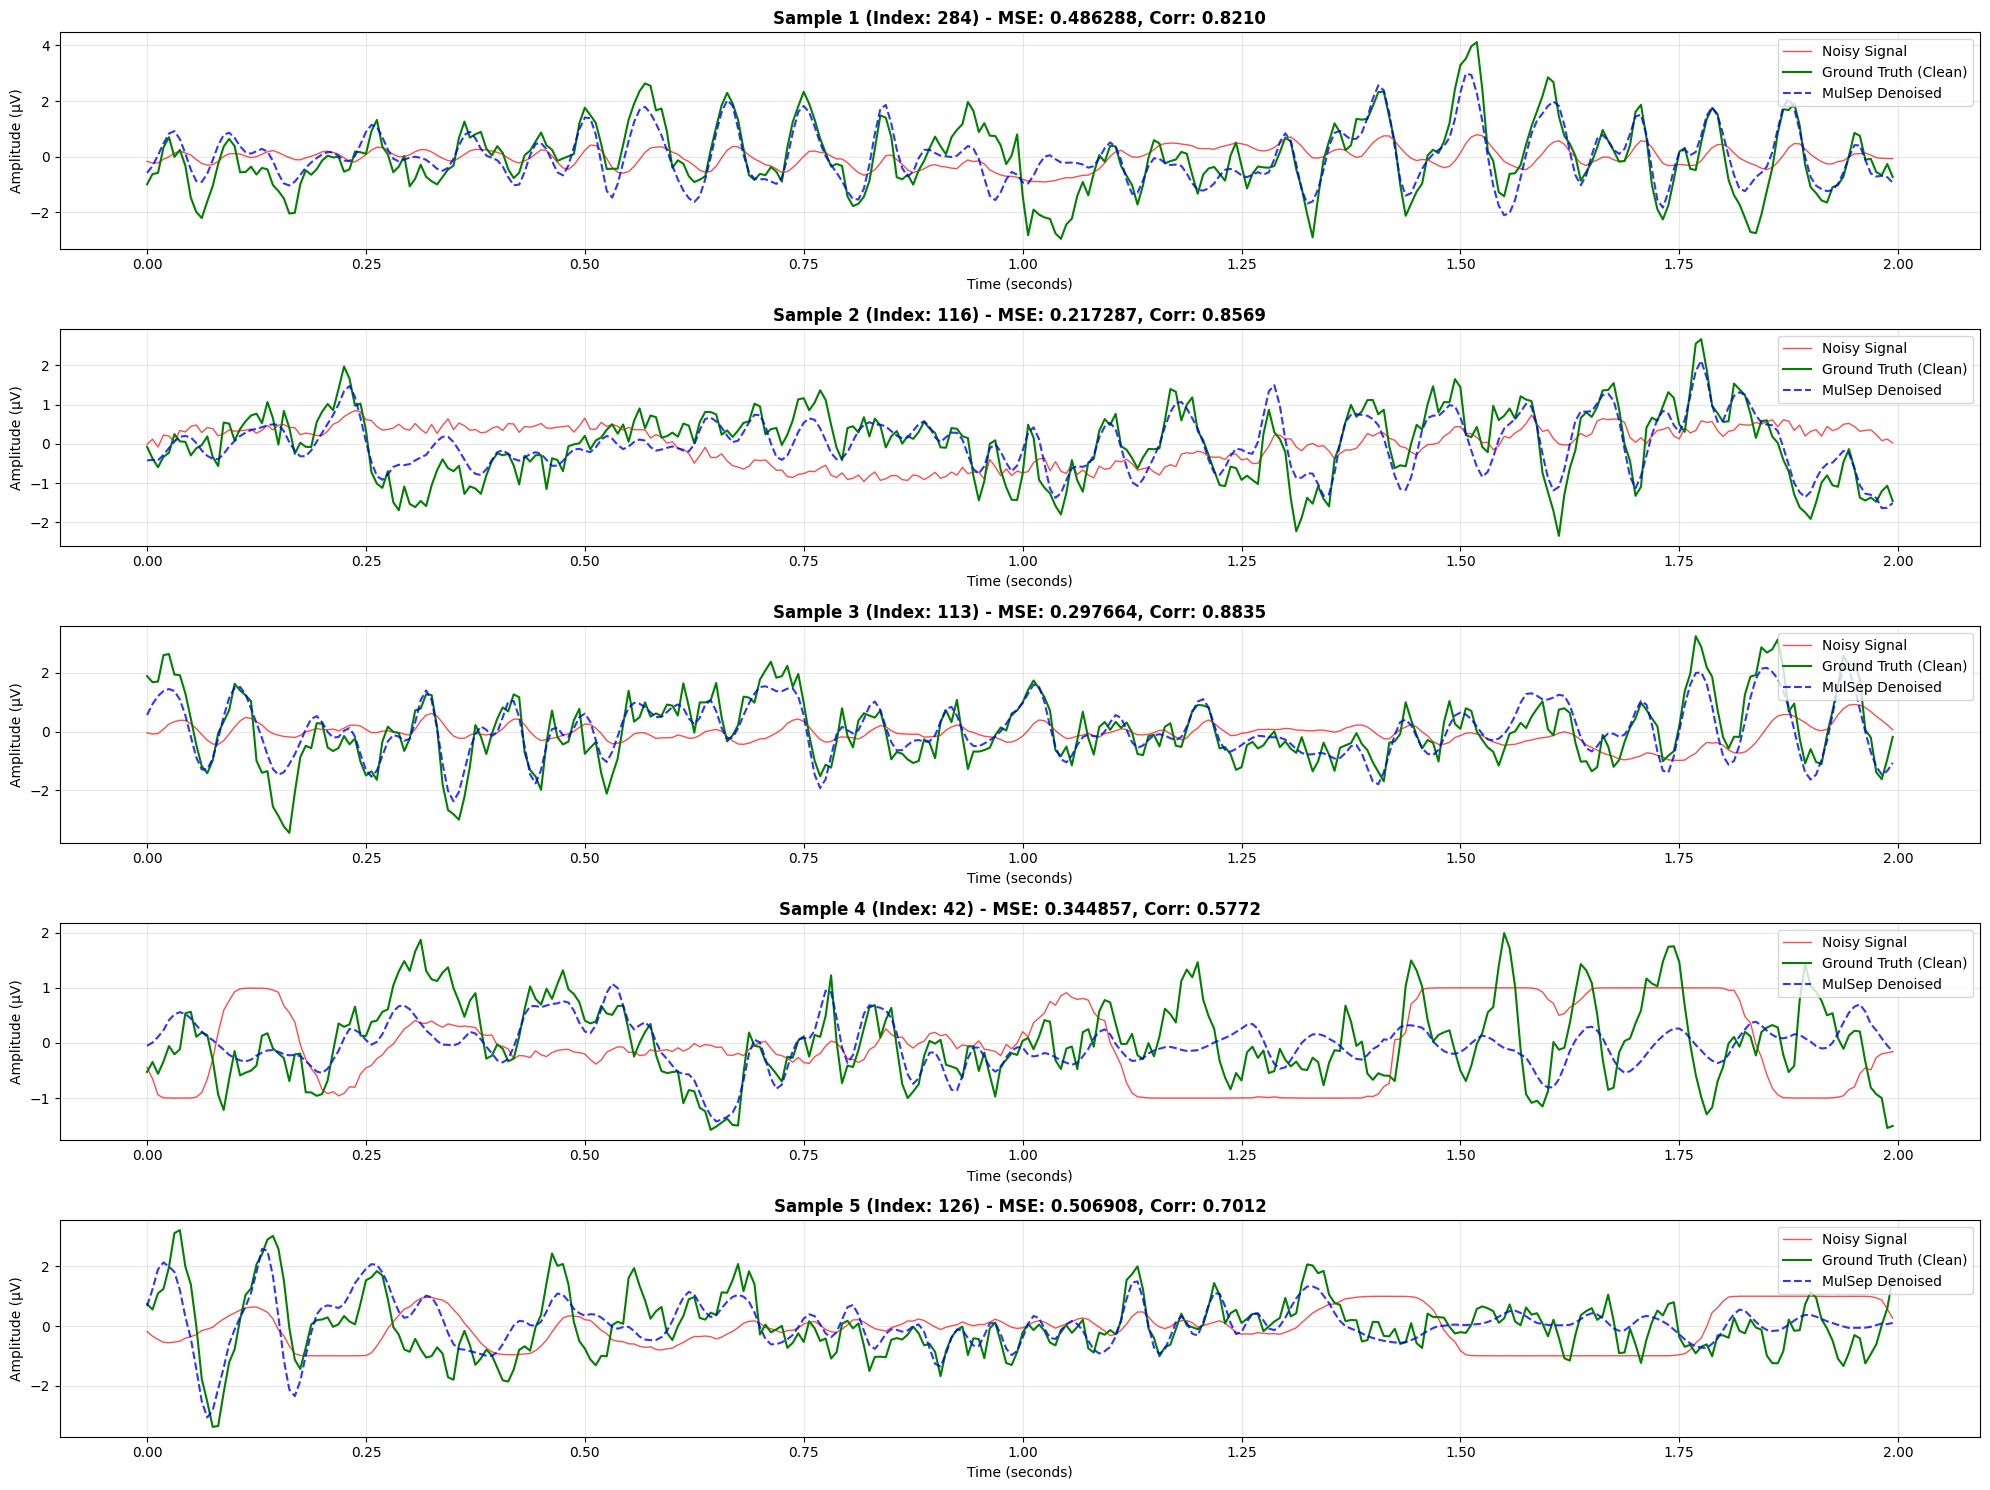


📈 CREATING DETAILED VISUALIZATION FOR SAMPLE 1...


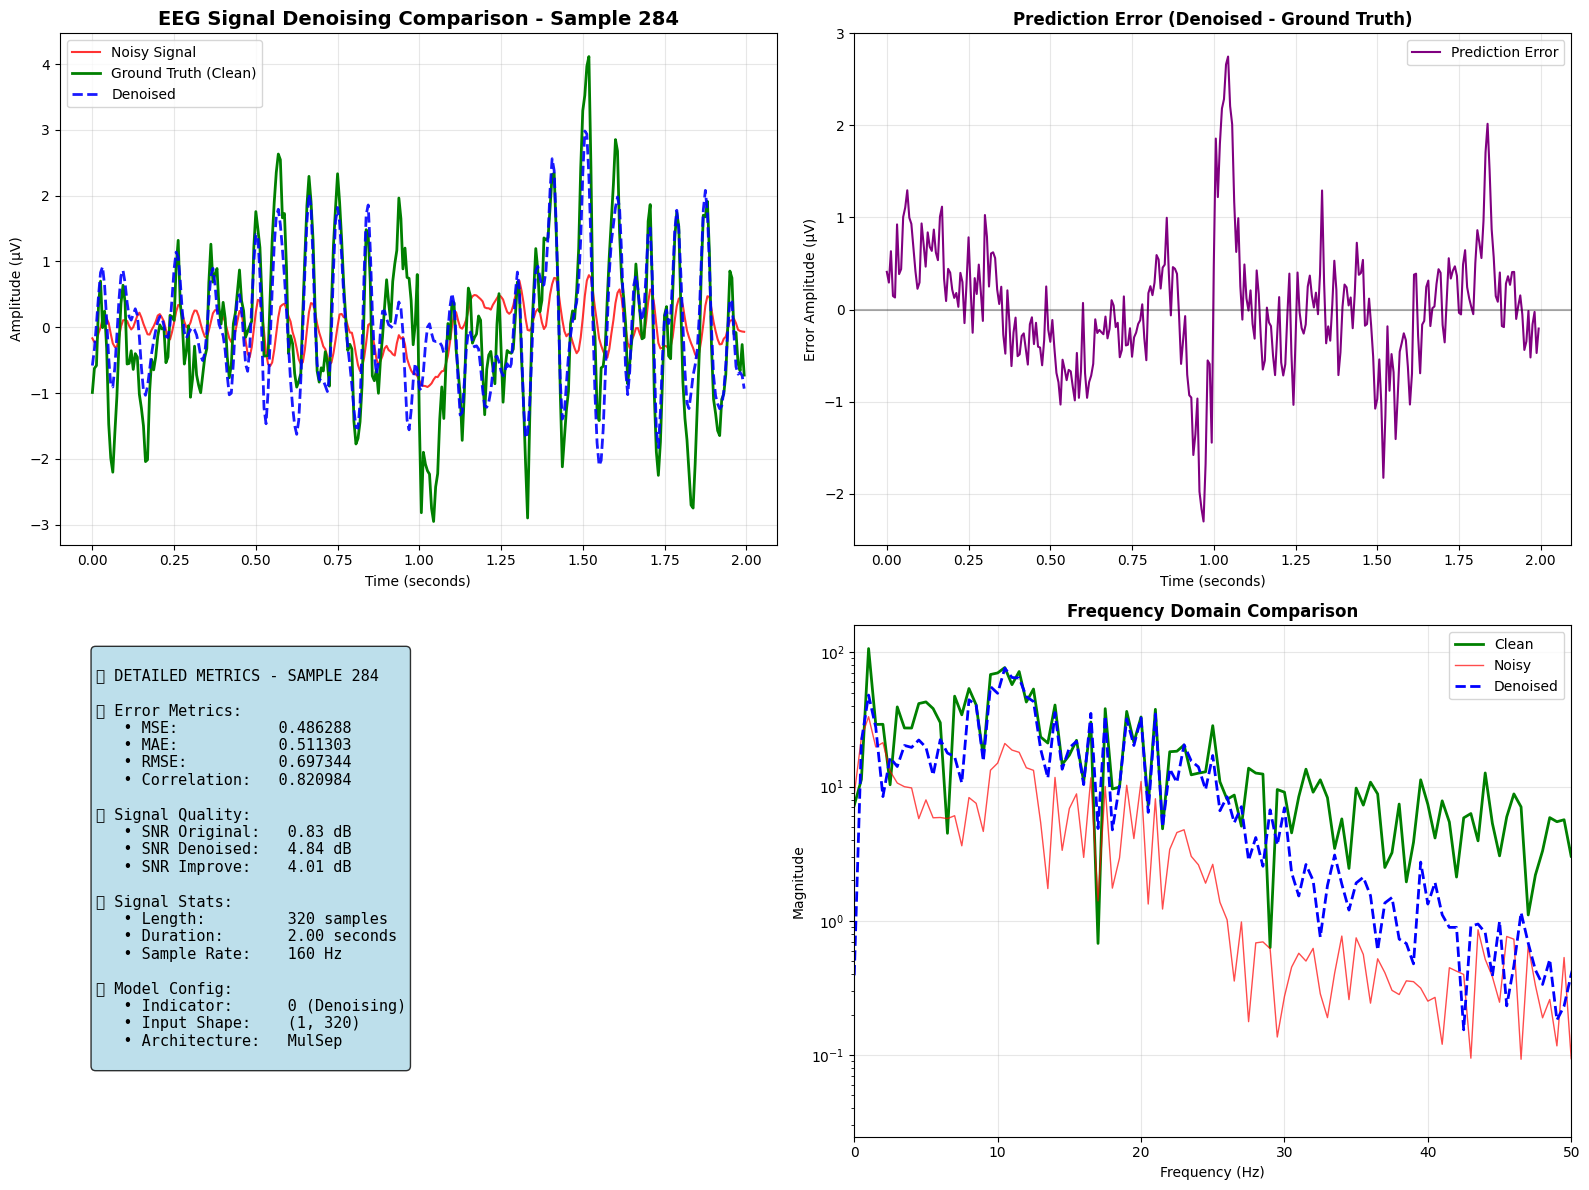


📊 CALCULATING METRICS FOR ALL 5 SAMPLES...


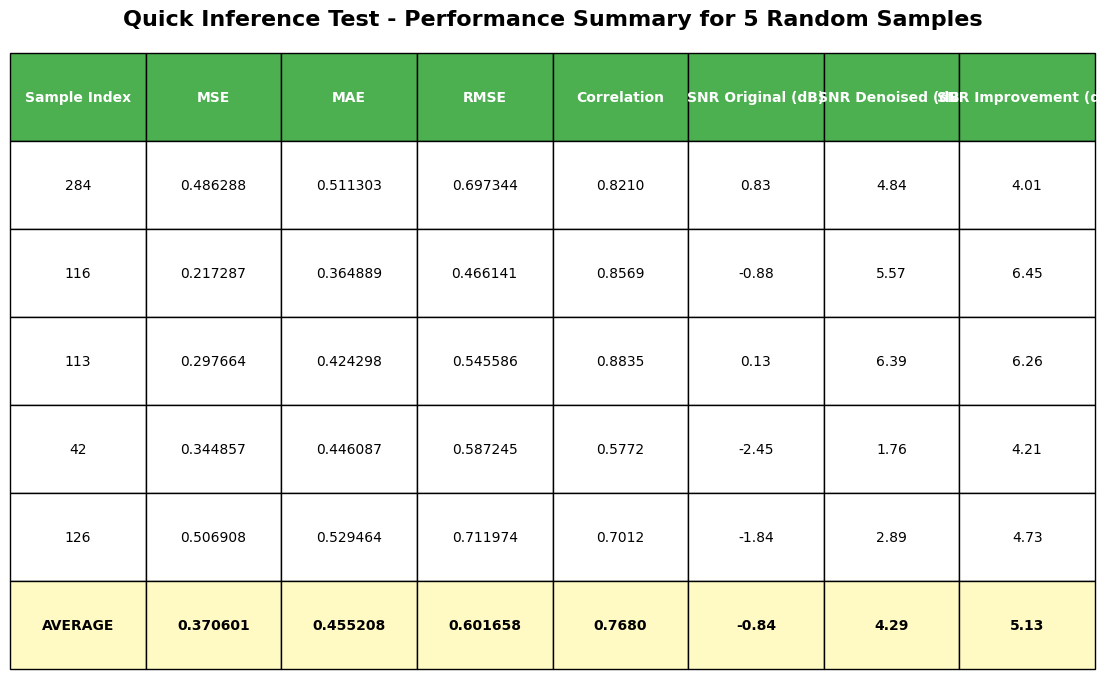


💾 SAVING INFERENCE TEST RESULTS...
✅ Inference results saved to: /content/drive/MyDrive/PropMod/quick_inference_results.json
✅ Signal data saved to: /content/drive/MyDrive/PropMod/quick_inference_signals.npz
✅ Visualizations saved:
   • All samples: /content/drive/MyDrive/PropMod/quick_inference_test_all_samples.png
   • Detailed sample: /content/drive/MyDrive/PropMod/quick_inference_detailed_sample_284.png
   • Summary table: /content/drive/MyDrive/PropMod/quick_inference_summary_table.png

🎉 MODIFIED QUICK INFERENCE TEST COMPLETED!
📊 Average Performance Across 5 Random Samples:
   • MSE:           0.370601
   • Correlation:   0.7680
   • SNR Improve:   5.13 dB
📂 All results saved in: /content/drive/MyDrive/PropMod

🔍 DATA TYPE VERIFICATION:
   random_indices type: <class 'int'>
   test_mse type: <class 'float'>
   sample_metrics[0]['mse'] type: <class 'float'>
   sequence_length type: <class 'int'>
✅ All data types should be native Python types (int, float, str) for JSON serializati

In [ ]:
# =============================================================================
# CELL 11: FIXED QUICK INFERENCE TEST WITH VISUALIZATION
# =============================================================================

import json
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

print("\n🧪 MODIFIED QUICK INFERENCE TEST WITH VISUALIZATION...")

# Load best model
model.load_state_dict(torch.load(f'{checkpoint_dir}/best_model.pkl'))
model.eval()

# Select 5 random samples from test set instead of validation set
test_samples = 5
np.random.seed(42)  # For reproducible results
random_indices = np.random.choice(len(test_noisy), test_samples, replace=False)

print(f"📊 Selected random test sample indices: {random_indices}")

# Get the random samples
test_input_random = test_input_tensor[random_indices].to(device)  # Shape: (5, 1, 320)
test_output_true_random = test_output_tensor[random_indices].to(device)  # Shape: (5, 1, 320)

# 🔥 FIX: Ensure consistent shapes for visualization data
test_noisy_random = test_noisy[random_indices]  # Original noisy signals
test_clean_random = test_clean[random_indices]  # Original clean signals

# Debug: Print shapes to understand the issue
print(f"🔍 Debug - test_noisy shape: {test_noisy.shape}")
print(f"🔍 Debug - test_clean shape: {test_clean.shape}")
print(f"🔍 Debug - test_noisy_random shape: {test_noisy_random.shape}")
print(f"🔍 Debug - test_clean_random shape: {test_clean_random.shape}")

# 🔥 FIX: Ensure 2D arrays (samples, sequence_length) for visualization
if test_noisy_random.ndim == 3:
    test_noisy_random = test_noisy_random.squeeze(-1)  # Remove last dimension if it exists
if test_clean_random.ndim == 3:
    test_clean_random = test_clean_random.squeeze(-1)  # Remove last dimension if it exists

print(f"✅ After squeeze - test_noisy_random shape: {test_noisy_random.shape}")
print(f"✅ After squeeze - test_clean_random shape: {test_clean_random.shape}")

# Create indicator tensor for denoising mode (all zeros)
test_indicator = torch.zeros(test_samples, dtype=torch.long).to(device)  # All 0s for denoising

print(f"✅ Test input shape: {test_input_random.shape}")
print(f"✅ Test output true shape: {test_output_true_random.shape}")
print(f"✅ Test indicator shape: {test_indicator.shape}")

# Perform inference
with torch.no_grad():
    test_output_pred = model(test_input_random, test_indicator)

print(f"✅ Inference completed. Prediction shape: {test_output_pred.shape}")

# Calculate test metrics
test_mse = F.mse_loss(test_output_pred, test_output_true_random).item()
test_mae = F.l1_loss(test_output_pred, test_output_true_random).item()

print(f"✅ Inference test metrics:")
print(f"   Test MSE: {test_mse:.6f}")
print(f"   Test MAE: {test_mae:.6f}")

# Convert predictions back to numpy for visualization
predictions_np = test_output_pred.cpu().numpy().squeeze(1)  # Remove channel dimension: (5, 320)

print(f"✅ Predictions converted to numpy. Shape: {predictions_np.shape}")

# 🔥 VERIFICATION: Ensure all arrays have compatible shapes
print(f"🔍 Final shape verification:")
print(f"   test_noisy_random: {test_noisy_random.shape}")
print(f"   test_clean_random: {test_clean_random.shape}")
print(f"   predictions_np: {predictions_np.shape}")

# Verify shapes are compatible for correlation calculation
assert test_noisy_random.shape == test_clean_random.shape == predictions_np.shape, \
    f"Shape mismatch: noisy={test_noisy_random.shape}, clean={test_clean_random.shape}, pred={predictions_np.shape}"

print("✅ All arrays have compatible shapes for visualization!")

# =============================================================================
# CREATE VISUALIZATION FOR ALL 5 SAMPLES
# =============================================================================

print("\n📈 CREATING VISUALIZATIONS FOR ALL 5 RANDOM SAMPLES...")

# Create time axis
time_axis = np.arange(sequence_length) / sampling_rate  # Convert to seconds

# Create figure for all 5 samples
plt.figure(figsize=(20, 15))

# Create a comprehensive visualization showing all samples
for i in range(test_samples):
    # Create subplot for each sample (5 rows, 1 column)
    plt.subplot(test_samples, 1, i + 1)

    # Plot all three signals
    plt.plot(time_axis, test_noisy_random[i], 'r-', label='Noisy Signal', linewidth=1, alpha=0.7)
    plt.plot(time_axis, test_clean_random[i], 'g-', label='Ground Truth (Clean)', linewidth=1.5)
    plt.plot(time_axis, predictions_np[i], 'b--', label='MulSep Denoised', linewidth=1.5, alpha=0.8)

    # Calculate metrics for this sample
    sample_mse = np.mean((test_clean_random[i] - predictions_np[i]) ** 2)

    # 🔥 FIX: Add error handling for correlation calculation
    try:
        sample_correlation, _ = pearsonr(test_clean_random[i], predictions_np[i])
        if np.isnan(sample_correlation):
            sample_correlation = 0.0
    except Exception as e:
        print(f"Warning: Could not calculate correlation for sample {i}: {e}")
        sample_correlation = 0.0

    plt.title(f'Sample {i+1} (Index: {random_indices[i]}) - MSE: {sample_mse:.6f}, Corr: {sample_correlation:.4f}',
              fontsize=12, fontweight='bold')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude (μV)')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{main_dir}/quick_inference_test_all_samples.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# CREATE INDIVIDUAL DETAILED VISUALIZATION FOR SAMPLE 1
# =============================================================================

print("\n📈 CREATING DETAILED VISUALIZATION FOR SAMPLE 1...")

# Select the first sample for detailed visualization
sample_idx = 0
selected_sample_idx = random_indices[sample_idx]

plt.figure(figsize=(16, 12))

# Main comparison plot
plt.subplot(2, 2, 1)
plt.plot(time_axis, test_noisy_random[sample_idx], 'r-', label='Noisy Signal', linewidth=1.5, alpha=0.8)
plt.plot(time_axis, test_clean_random[sample_idx], 'g-', label='Ground Truth (Clean)', linewidth=2)
plt.plot(time_axis, predictions_np[sample_idx], 'b--', label='Denoised', linewidth=2, alpha=0.9)

plt.title(f'EEG Signal Denoising Comparison - Sample {selected_sample_idx}', fontsize=14, fontweight='bold')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (μV)')
plt.legend()
plt.grid(True, alpha=0.3)

# Error analysis plot
plt.subplot(2, 2, 2)
error_signal = predictions_np[sample_idx] - test_clean_random[sample_idx]
plt.plot(time_axis, error_signal, 'purple', linewidth=1.5, label='Prediction Error')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title(f'Prediction Error (Denoised - Ground Truth)', fontsize=12, fontweight='bold')
plt.xlabel('Time (seconds)')
plt.ylabel('Error Amplitude (μV)')
plt.legend()
plt.grid(True, alpha=0.3)

# Calculate and display detailed metrics
sample_mse = np.mean((test_clean_random[sample_idx] - predictions_np[sample_idx]) ** 2)
sample_mae = np.mean(np.abs(test_clean_random[sample_idx] - predictions_np[sample_idx]))
sample_rmse = np.sqrt(sample_mse)

# 🔥 FIX: Safe correlation calculation
try:
    sample_correlation, _ = pearsonr(test_clean_random[sample_idx], predictions_np[sample_idx])
    if np.isnan(sample_correlation):
        sample_correlation = 0.0
except Exception as e:
    print(f"Warning: Could not calculate correlation: {e}")
    sample_correlation = 0.0

# SNR calculation with safety checks
signal_power = np.var(test_clean_random[sample_idx])
noise_power_original = np.var(test_noisy_random[sample_idx] - test_clean_random[sample_idx])
noise_power_denoised = np.var(predictions_np[sample_idx] - test_clean_random[sample_idx])

snr_original = 10 * np.log10(signal_power / noise_power_original) if noise_power_original > 0 else float('inf')
snr_denoised = 10 * np.log10(signal_power / noise_power_denoised) if noise_power_denoised > 0 else float('inf')
snr_improvement = snr_denoised - snr_original if np.isfinite(snr_denoised) and np.isfinite(snr_original) else 0

# Metrics text box
plt.subplot(2, 2, 3)
plt.axis('off')
metrics_text = f"""
📊 DETAILED METRICS - SAMPLE {selected_sample_idx}

🔢 Error Metrics:
   • MSE:           {sample_mse:.6f}
   • MAE:           {sample_mae:.6f}
   • RMSE:          {sample_rmse:.6f}
   • Correlation:   {sample_correlation:.6f}

📡 Signal Quality:
   • SNR Original:   {snr_original:.2f} dB
   • SNR Denoised:   {snr_denoised:.2f} dB
   • SNR Improve:    {snr_improvement:.2f} dB

📏 Signal Stats:
   • Length:         {sequence_length} samples
   • Duration:       {sequence_length/sampling_rate:.2f} seconds
   • Sample Rate:    {sampling_rate} Hz

🎯 Model Config:
   • Indicator:      0 (Denoising)
   • Input Shape:    (1, {sequence_length})
   • Architecture:   MulSep
"""

plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
         fontsize=11, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Frequency domain comparison
plt.subplot(2, 2, 4)
# Calculate FFT for frequency analysis
freq_axis = np.fft.fftfreq(sequence_length, 1/sampling_rate)
positive_freq_mask = freq_axis >= 0

fft_clean = np.abs(np.fft.fft(test_clean_random[sample_idx]))
fft_noisy = np.abs(np.fft.fft(test_noisy_random[sample_idx]))
fft_denoised = np.abs(np.fft.fft(predictions_np[sample_idx]))

plt.semilogy(freq_axis[positive_freq_mask], fft_clean[positive_freq_mask], 'g-', label='Clean', linewidth=2)
plt.semilogy(freq_axis[positive_freq_mask], fft_noisy[positive_freq_mask], 'r-', label='Noisy', linewidth=1, alpha=0.7)
plt.semilogy(freq_axis[positive_freq_mask], fft_denoised[positive_freq_mask], 'b--', label='Denoised', linewidth=2)

plt.title('Frequency Domain Comparison', fontsize=12, fontweight='bold')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, min(50, sampling_rate//2))  # Limit to EEG relevant frequencies

plt.tight_layout()
plt.savefig(f'{main_dir}/quick_inference_detailed_sample_{selected_sample_idx}.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# CREATE SUMMARY TABLE FOR ALL 5 SAMPLES (WITH SAFE CALCULATIONS)
# =============================================================================

print("\n📊 CALCULATING METRICS FOR ALL 5 SAMPLES...")

# Calculate metrics for all samples with error handling
sample_metrics = []
for i in range(test_samples):
    sample_mse = np.mean((test_clean_random[i] - predictions_np[i]) ** 2)
    sample_mae = np.mean(np.abs(test_clean_random[i] - predictions_np[i]))
    sample_rmse = np.sqrt(sample_mse)

    # Safe correlation calculation
    try:
        sample_correlation, _ = pearsonr(test_clean_random[i], predictions_np[i])
        if np.isnan(sample_correlation):
            sample_correlation = 0.0
    except Exception as e:
        print(f"Warning: Could not calculate correlation for sample {i}: {e}")
        sample_correlation = 0.0

    # SNR calculation with safety checks
    signal_power = np.var(test_clean_random[i])
    noise_power_original = np.var(test_noisy_random[i] - test_clean_random[i])
    noise_power_denoised = np.var(predictions_np[i] - test_clean_random[i])

    snr_original = 10 * np.log10(signal_power / noise_power_original) if noise_power_original > 0 else float('inf')
    snr_denoised = 10 * np.log10(signal_power / noise_power_denoised) if noise_power_denoised > 0 else float('inf')
    snr_improvement = snr_denoised - snr_original if np.isfinite(snr_denoised) and np.isfinite(snr_original) else 0

    sample_metrics.append({
        'sample_idx': int(random_indices[i]),  # Convert to native Python int
        'mse': float(sample_mse),
        'mae': float(sample_mae),
        'rmse': float(sample_rmse),
        'correlation': float(sample_correlation),
        'snr_original': float(snr_original) if np.isfinite(snr_original) else 0.0,
        'snr_denoised': float(snr_denoised) if np.isfinite(snr_denoised) else 0.0,
        'snr_improvement': float(snr_improvement)
    })

# Create summary table visualization
plt.figure(figsize=(14, 8))
plt.axis('off')

# Prepare data for table
table_data = []
headers = ['Sample Index', 'MSE', 'MAE', 'RMSE', 'Correlation', 'SNR Original (dB)', 'SNR Denoised (dB)', 'SNR Improvement (dB)']

for metric in sample_metrics:
    row = [
        f"{metric['sample_idx']}",
        f"{metric['mse']:.6f}",
        f"{metric['mae']:.6f}",
        f"{metric['rmse']:.6f}",
        f"{metric['correlation']:.4f}",
        f"{metric['snr_original']:.2f}",
        f"{metric['snr_denoised']:.2f}",
        f"{metric['snr_improvement']:.2f}"
    ]
    table_data.append(row)

# Add average row
avg_metrics = {
    'mse': float(np.mean([m['mse'] for m in sample_metrics])),
    'mae': float(np.mean([m['mae'] for m in sample_metrics])),
    'rmse': float(np.mean([m['rmse'] for m in sample_metrics])),
    'correlation': float(np.mean([m['correlation'] for m in sample_metrics])),
    'snr_original': float(np.mean([m['snr_original'] for m in sample_metrics if np.isfinite(m['snr_original'])])),
    'snr_denoised': float(np.mean([m['snr_denoised'] for m in sample_metrics if np.isfinite(m['snr_denoised'])])),
    'snr_improvement': float(np.mean([m['snr_improvement'] for m in sample_metrics if np.isfinite(m['snr_improvement'])]))
}

avg_row = [
    "AVERAGE",
    f"{avg_metrics['mse']:.6f}",
    f"{avg_metrics['mae']:.6f}",
    f"{avg_metrics['rmse']:.6f}",
    f"{avg_metrics['correlation']:.4f}",
    f"{avg_metrics['snr_original']:.2f}",
    f"{avg_metrics['snr_denoised']:.2f}",
    f"{avg_metrics['snr_improvement']:.2f}"
]
table_data.append(avg_row)

# Create table
table = plt.table(cellText=table_data,
                  colLabels=headers,
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style the table
for i in range(len(headers)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Highlight average row
for i in range(len(headers)):
    table[(len(sample_metrics) + 1, i)].set_facecolor('#FFF9C4')
    table[(len(sample_metrics) + 1, i)].set_text_props(weight='bold')

plt.title('Quick Inference Test - Performance Summary for 5 Random Samples',
          fontsize=16, fontweight='bold', pad=20)
plt.savefig(f'{main_dir}/quick_inference_summary_table.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# SAVE INFERENCE RESULTS (FIXED JSON SERIALIZATION)
# =============================================================================

print("\n💾 SAVING INFERENCE TEST RESULTS...")

# 🔥 FIXED: Proper NumPy type conversion function
def convert_numpy_types(obj):
    """Recursively convert NumPy data types to native Python types for JSON serialization"""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    elif isinstance(obj, tuple):
        return tuple(convert_numpy_types(item) for item in obj)
    else:
        return obj

# Prepare inference results with proper type conversion
inference_results = {
    'random_indices': [int(idx) for idx in random_indices],  # Convert to Python int
    'test_mse': float(test_mse),  # Convert to Python float
    'test_mae': float(test_mae),  # Convert to Python float
    'sample_metrics': sample_metrics,  # Already converted above
    'average_metrics': avg_metrics,  # Already converted above
    'model_config': {
        'sequence_length': int(sequence_length),  # Convert to Python int
        'sampling_rate': int(sampling_rate),  # Convert to Python int
        'batch_size': int(test_samples),  # Convert to Python int
        'indicator_mode': 0,  # Already Python int
        'device': str(device)  # Convert to string
    }
}

# Apply conversion function to ensure all NumPy types are converted
inference_results_clean = convert_numpy_types(inference_results)

# 🔥 FIXED: Safe JSON saving with error handling
try:
    with open(f'{main_dir}/quick_inference_results.json', 'w') as f:
        json.dump(inference_results_clean, f, indent=4)
    print(f"✅ Inference results saved to: {main_dir}/quick_inference_results.json")
except Exception as e:
    print(f"❌ Error saving JSON: {e}")
    print("Attempting to save without problematic data...")

    # Fallback: Save minimal results if full save fails
    minimal_results = {
        'test_mse': float(test_mse),
        'test_mae': float(test_mae),
        'random_indices': [int(idx) for idx in random_indices],
        'average_metrics': {
            'mse': float(avg_metrics['mse']),
            'correlation': float(avg_metrics['correlation'])
        }
    }

    with open(f'{main_dir}/quick_inference_results_minimal.json', 'w') as f:
        json.dump(minimal_results, f, indent=4)
    print(f"✅ Minimal results saved to: {main_dir}/quick_inference_results_minimal.json")

# Save the actual signals for further analysis
try:
    np.savez(f'{main_dir}/quick_inference_signals.npz',
             noisy_signals=test_noisy_random,
             clean_signals=test_clean_random,
             denoised_signals=predictions_np,
             random_indices=random_indices)
    print(f"✅ Signal data saved to: {main_dir}/quick_inference_signals.npz")
except Exception as e:
    print(f"❌ Error saving signal data: {e}")

print(f"✅ Visualizations saved:")
print(f"   • All samples: {main_dir}/quick_inference_test_all_samples.png")
print(f"   • Detailed sample: {main_dir}/quick_inference_detailed_sample_{random_indices[0]}.png")
print(f"   • Summary table: {main_dir}/quick_inference_summary_table.png")

print(f"\n🎉 MODIFIED QUICK INFERENCE TEST COMPLETED!")
print(f"📊 Average Performance Across 5 Random Samples:")
print(f"   • MSE:           {avg_metrics['mse']:.6f}")
print(f"   • Correlation:   {avg_metrics['correlation']:.4f}")
print(f"   • SNR Improve:   {avg_metrics['snr_improvement']:.2f} dB")
print(f"📂 All results saved in: {main_dir}")

# =============================================================================
# ADDITIONAL DEBUG: Print data types to verify conversion
# =============================================================================

print(f"\n🔍 DATA TYPE VERIFICATION:")
print(f"   random_indices type: {type(inference_results_clean['random_indices'][0])}")
print(f"   test_mse type: {type(inference_results_clean['test_mse'])}")
print(f"   sample_metrics[0]['mse'] type: {type(inference_results_clean['sample_metrics'][0]['mse'])}")
print(f"   sequence_length type: {type(inference_results_clean['model_config']['sequence_length'])}")
print("✅ All data types should be native Python types (int, float, str) for JSON serialization")